In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt

# inline magic changes figsize, set it again here
import matplotlib
matplotlib.rcParams['figure.figsize'] = 8,6 
default_color_list = plt.rcParams['axes.prop_cycle'].by_key()['color'] # get default colors

from astropy.table import Table
from astropy.io import ascii
import math
import pathos.multiprocessing as mp

# File Wrangling
Unfortunately, the best way to match the file names to the cosmological parameters text file is to use $A_s$, which we do here. The fiducial models 1a and 1b share the same $A_s$, so we put those in by hand.

In [3]:
# get all the names of the cosmology folders
folders = os.listdir('data/May_stats/')

# helper function for extracting the numerical value of As from a filename
def get_As( string_with_As ):
    return float(string_with_As.split('_As')[1].split('_mva')[0])

# read in list of simulation cosmo parameters
table = Table.read('cosmological_parameters.txt', format='ascii')

# now combine tables
new_filename_row = []
for row in table:
    # match based on 10^9*A_s column name
    filename_candidates = [x for x in folders 
                           if np.isclose(row['10^9*A_s'],get_As(x), atol=1e-4)]
    
    if '1a(fiducial)' in row['Model']:
        fname = 'Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995'
    elif '1b(fiducial)' in row['Model']:
        fname = 'Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995'
    else:
        # make sure we have exactly one match
        assert len(filename_candidates) == 1
        fname = filename_candidates[0]
        
    new_filename_row.append( fname )
    
table['filename'] = new_filename_row
table.write('parameters.table', format='ascii', overwrite=True)

In [4]:
# dictionary for getting the appropriate ng for a redshift
ng_dict = {
    '05' : '08.83',
    '10' : '13.25',
    '15' : '11.15',
    '20' : '07.36',
    '25' : '04.26',
    '10_ng40' : '40.00'
}

In [5]:
def get_meanstack(observable_name, noisy, redshift, smoothing,  
                  bin_min, bin_max, binning='050', binscale='', bin_center_row = 0, max_realizations=10000):
    """
    observable_name (str) : 'PS' or 'Peaks'
    noisy (str) : 'K' or 'KN' for noiseless and noisy respectively
    redshift (string): ex. '05'
    smoothing (string) : s0.00
    binning (string) : number of bins
    binscale (string) : lin or log
    bin_center_row (int) : refers to if we want to use the kappa (use integer 0) 
                           or SN (use the integer 1)
    returns: tuple,
        (array (either ell or kappa), array(mean_stack))
        where mean_stack is 101 rows, stacked PS or PC
    """
    
    mean_stack_list = []
    
    for row in table:
        
        # file wrangling
        if row['Model'] == '1a(fiducial)':
            modifier = '/box1' # use box1 for means, use box5 for covariance
        else: 
            modifier = ''
            
        if redshift == '10_ng40':
            fname = '%s_%s_s%s_z%.2f_ng%s_b%s%s' % (observable_name, noisy, smoothing, 
                                                      1.0, ng_dict[redshift], 
                                                    binning, binscale)
            meandir = 'data/May_stats/%s/Maps%s/%s_Mean.npy' % (row['filename'] + modifier, 
                                            redshift, fname)
            fdir = 'data/May_stats/%s/Maps%s/%s.npy' % (row['filename'] + modifier, 
                                            redshift, fname)
        else:
            fname = '%s_%s_s%s_z%.2f_ng%s_b%s%s' % (observable_name, noisy, smoothing, 
                                                      float(redshift)/10, ng_dict[redshift], 
                                                    binning, binscale)
            meandir = 'data/May_stats/%s/Maps%s/%s_Mean.npy' % (row['filename'] + modifier, 
                                            redshift, fname)
            fdir = 'data/May_stats/%s/Maps%s/%s.npy' % (row['filename'] + modifier, 
                                            redshift, fname)
        
        # load in the file and split it up into meaningful stuff
#         obs_array_temp = np.load(meandir)
#         #if PS, ells are in first row
#         if observable_name == 'PS':
#             bin_centers = obs_array_temp[0]
#             mean_arr = obs_array_temp[1]
#         elif observable_name == 'Peaks':
#             bin_centers = obs_array_temp[bin_center_row]
#             mean_arr = obs_array_temp[2]

        obs_array_temp = np.load(fdir)
        if observable_name == 'PS':
            end_index = min( max_realizations+1, obs_array_temp.shape[0]-1 )
            bin_centers = obs_array_temp[0]
            mean_arr = np.mean(obs_array_temp[1:end_index],axis=0)
#             print(obs_array_temp[1:end_index].shape)
        elif observable_name == 'Peaks':
            end_index = min( max_realizations+2, obs_array_temp.shape[0]-1 )
            bin_centers = obs_array_temp[bin_center_row]
            mean_arr = np.mean(obs_array_temp[2:end_index],axis=0)
#             print(obs_array_temp[2:end_index].shape)
        
        
        filter_for_bins = np.logical_and(bin_min<bin_centers, bin_centers<bin_max)
        bin_centers = bin_centers[filter_for_bins]
        mean_arr = (mean_arr.T[filter_for_bins]).T 
        # add the model to the stack
        mean_stack_list.append(mean_arr)
    
    # return the stack of means, ordered like the table is
    return bin_centers, np.vstack(mean_stack_list)

def get_meanstack_multiz(observable_name, noisy, redshifts, smoothing,  
                         bin_min, bin_max, binning='050', binscale='',  bin_center_row = 0, max_realizations=10000):
    """
    get a horizontally stacked meanstack for multiple redshifts
    """
    
    bin_center_list = []
    stack_list = []
    for redshift in redshifts:
        # pass all arguments
        bin_centers, meanstack = get_meanstack(observable_name=observable_name, noisy=noisy, 
                                                redshift=redshift, smoothing=smoothing,  
                                                bin_min=bin_min, bin_max=bin_max, binning=binning, 
                                                binscale=binscale, bin_center_row=bin_center_row, max_realizations=max_realizations)
        bin_center_list.append( bin_centers )
        stack_list.append( meanstack )
        
    return np.hstack(bin_center_list), np.hstack(stack_list)

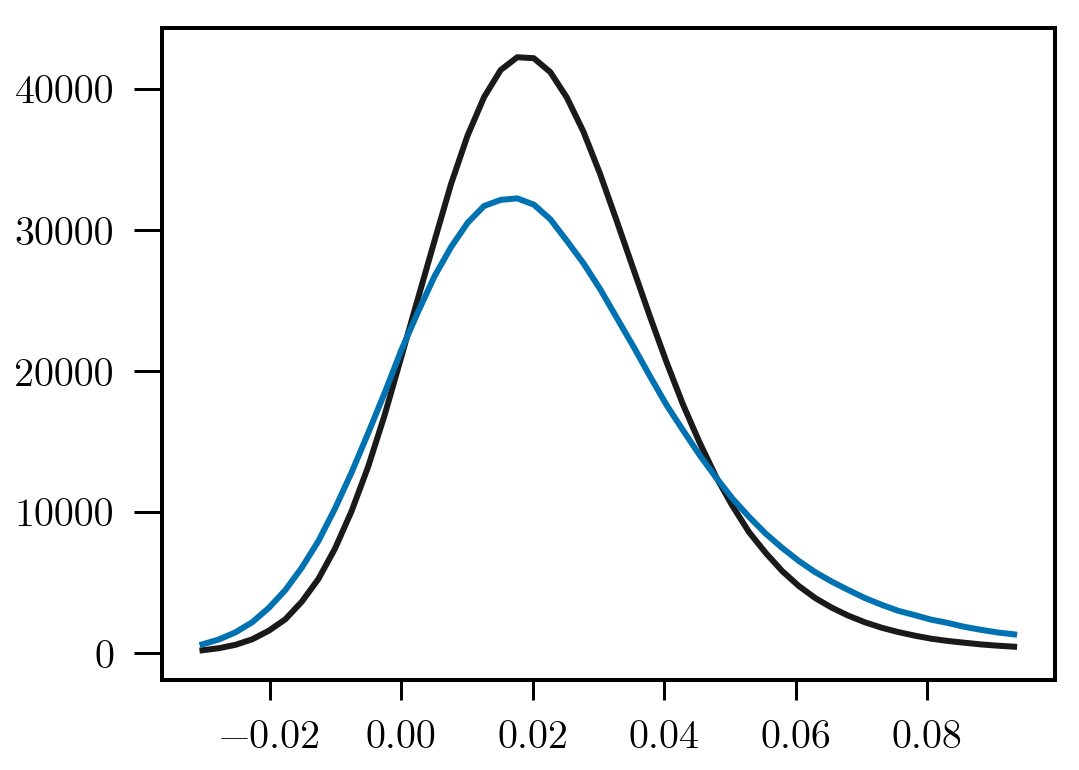

In [6]:
kappa, temp_ar = get_meanstack( 'Peaks', noisy='KN', redshift='10_ng40',  bin_min=-0.05, bin_max=0.2,
                               smoothing='1.00', max_realizations=5000 )
plt.plot( kappa, temp_ar[1])
plt.plot( kappa, temp_ar[2])
# plt.yscale('log'); plt.xscale('log');

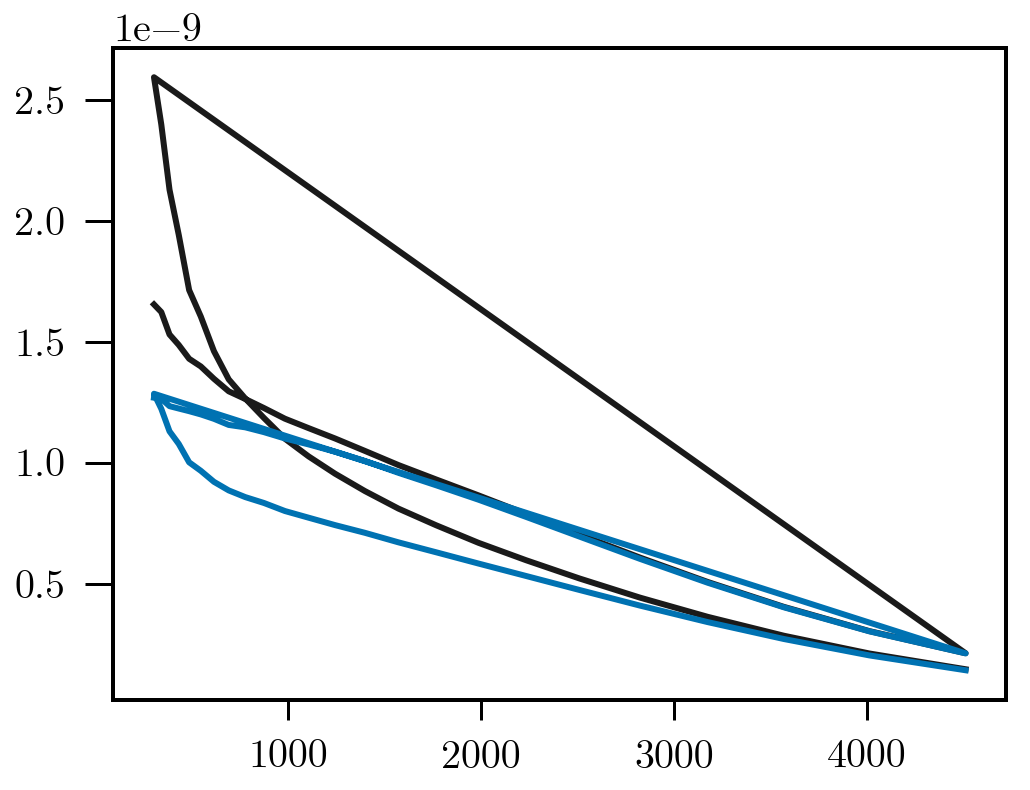

In [7]:
kappa, temp_ar = get_meanstack_multiz( 'PS', noisy='KN', redshifts=['05','10'],  bin_min=300, bin_max=5000,
                               smoothing='1.00', binscale='log', max_realizations=10000 )
plt.plot( kappa, temp_ar[1])
plt.plot( kappa, temp_ar[5])
# plt.yscale('log'); plt.xscale('log');

In [8]:
def get_invcov(observable_name, noisy, redshifts, smoothing, bin_min, bin_max,
               binning='050', binscale='', bin_center_row = 0, sky_coverage=1e4, verbose=True):
    """
    We only use the fiducial model's covariance.
    
    redshifts = list of redshifts to use
    """
    
    bin_center_list = []
    realization_list = []
    
    for redshift in redshifts:
        modifier = '/box5' # use box1 for means, use box5 for covariance
        if redshift == '10_ng40':
            fname = '%s_%s_s%s_z%.2f_ng%s_b%s%s' % (observable_name, noisy, smoothing, 
                                                      1.0, ng_dict[redshift], binning, binscale)
            fdir = 'data/May_stats/%s/Maps%s/%s.npy' % (table[0]['filename'] + modifier, 
                                                    redshift, fname)
        else:
            fname = '%s_%s_s%s_z%.2f_ng%s_b%s%s' % (observable_name, noisy, smoothing, 
                                                      float(redshift)/10, ng_dict[redshift], binning, binscale)
            fdir = 'data/May_stats/%s/Maps%s/%s.npy' % (table[0]['filename'] + modifier, 
                                                    redshift, fname)
            
        obs_array_temp = np.load(fdir)

        if observable_name == 'PS':
            bin_centers = obs_array_temp[0]
            realizations = obs_array_temp[1:]
        elif observable_name == 'Peaks':
            bin_centers = obs_array_temp[bin_center_row]
            realizations = obs_array_temp[2:]
            
        # filter out the bins we don't want, and then add to lists
        filter_for_bins = np.logical_and(bin_min<bin_centers, bin_centers<bin_max)
        bin_centers = bin_centers[filter_for_bins]
        realizations = (realizations.T[filter_for_bins]).T 
        bin_center_list.append(bin_centers)
        realization_list.append(realizations)
    
    realizations_stacked = np.hstack(realization_list)
    # now compute covariance
    cov = np.cov(realizations_stacked.T)

    nrealizations, nbins = realizations_stacked.shape
    bin_correction = (nrealizations - nbins - 2) / (nrealizations - 1)
    sky_correction = 12.25/sky_coverage
    
    if verbose: print('nr', nrealizations, 'nb', nbins, 
                      'bin', bin_correction, 'sky',sky_correction )

    # this 12.25/2e4 is from the LSST area divided by box, from Jia's email
    invcov = bin_correction * np.linalg.inv(cov * sky_correction)
    
    
    return invcov

nr 9999 nb 120 bin 0.9878975795159032 sky 0.001225
nr 9999 nb 182 bin 0.9816963392678536 sky 0.001225


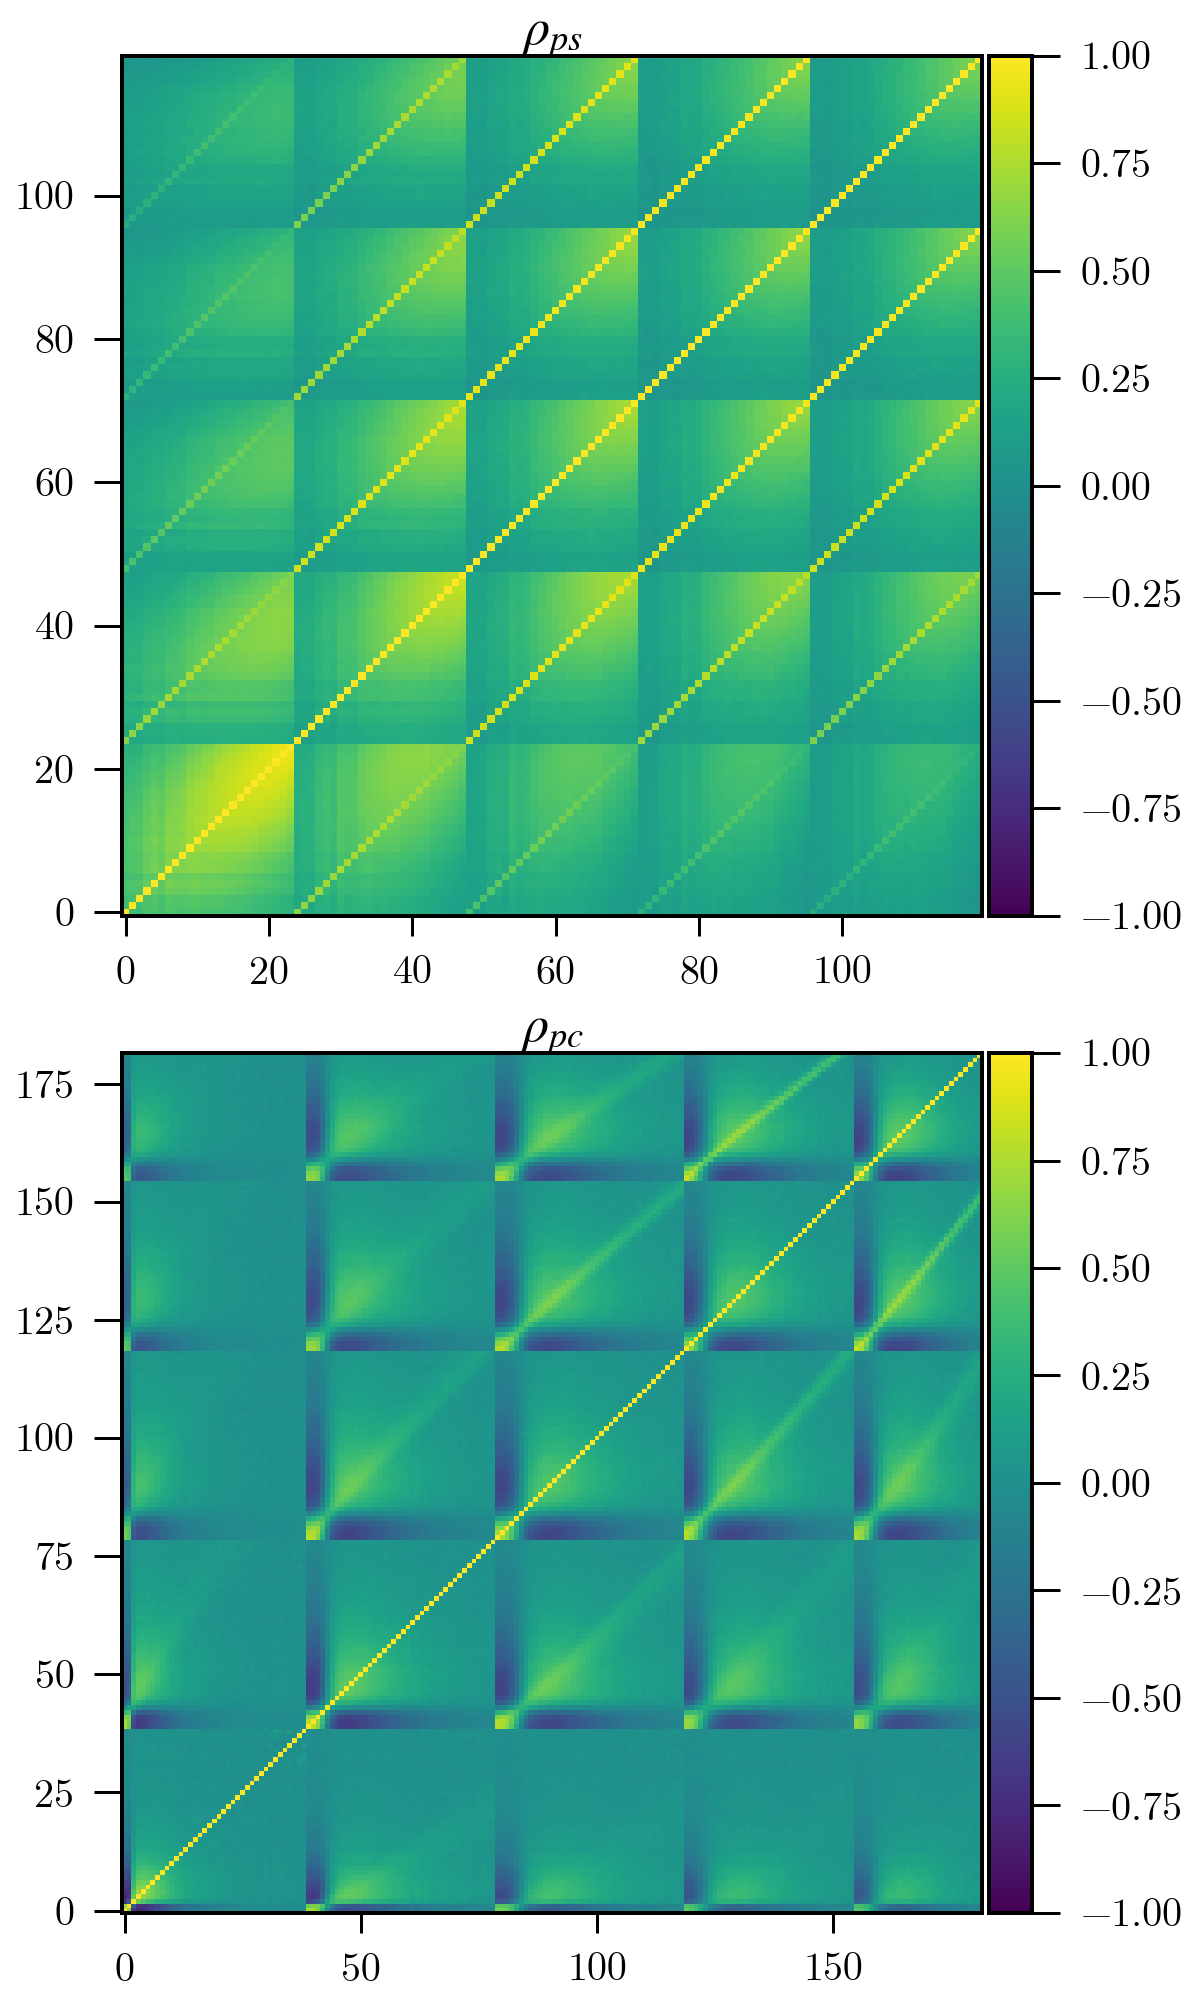

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

cov_ps = np.linalg.inv( get_invcov( 'PS', noisy='K', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=300, bin_max=5000,
                                   smoothing='1.00', binscale='log'  ) )
cov_pc = np.linalg.inv( get_invcov( 'Peaks', noisy='K', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=-0.01, bin_max=0.2,
                                   smoothing='1.00') )

fig, axes = plt.subplots(2,1,figsize=(8,14) )
D_ps = np.diag(1./np.sqrt(np.diag(cov_ps)))
cor_ps = np.dot(D_ps,  np.dot(cov_ps , D_ps))
mappable0 = axes[0].imshow(cor_ps, vmin=-1, vmax=1, origin='lower')

D_pc = np.diag(1./np.sqrt(np.diag(cov_pc)))
cor_pc = np.dot(D_pc,  np.dot(cov_pc , D_pc))
mappable1 = axes[1].imshow(cor_pc, vmin=-1, vmax=1, origin='lower')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(mappable0, cax=cax)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(mappable1, cax=cax)

axes[0].set_title(r'$\rho_{ps}$')
axes[1].set_title(r'$\rho_{pc}$')

plt.tight_layout()

nr 9999 nb 120 bin 0.9878975795159032 sky 0.001225
nr 9999 nb 219 bin 0.9779955991198239 sky 0.001225


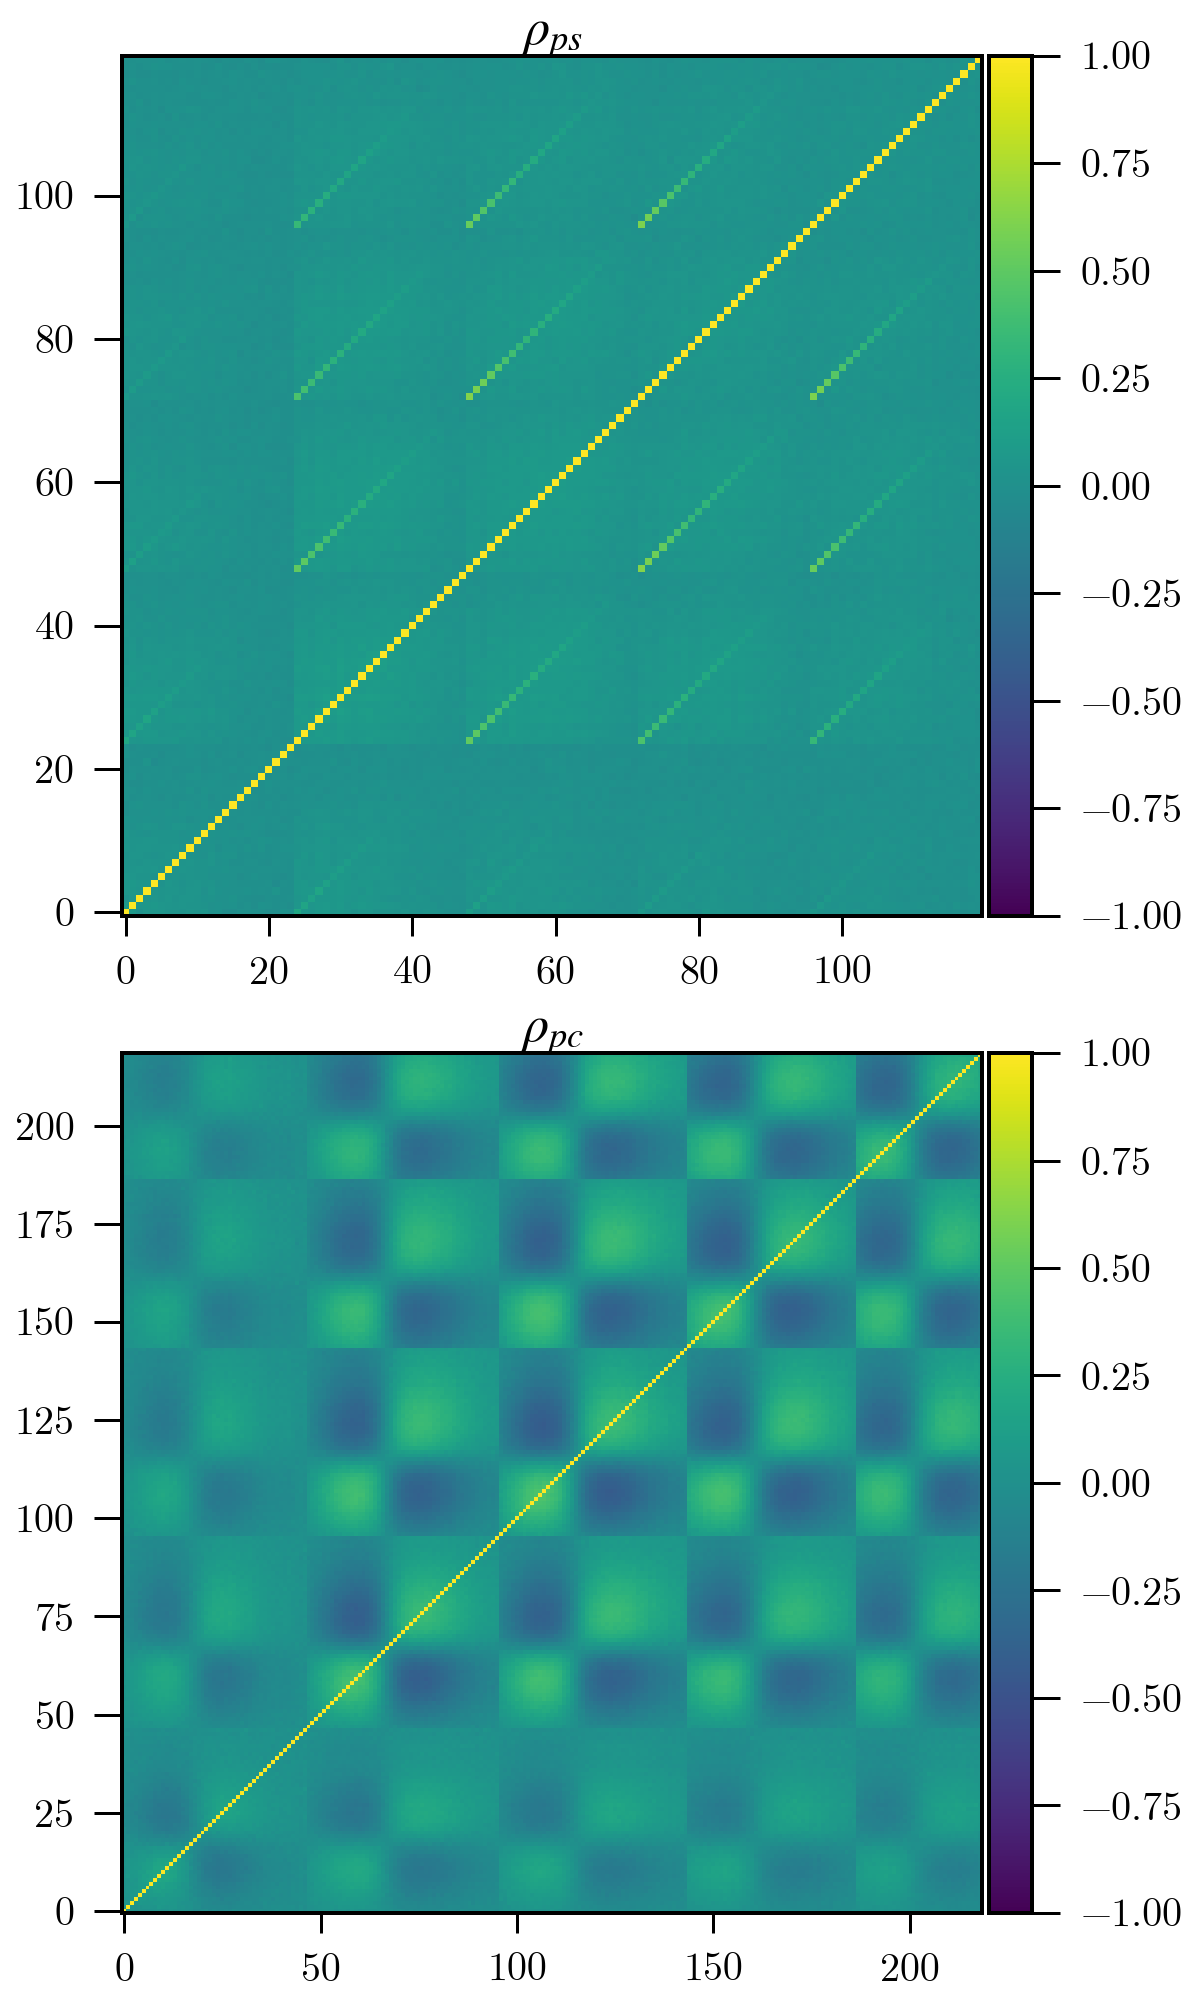

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

cov_ps = np.linalg.inv( get_invcov( 'PS', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=300, bin_max=5000,
                                   smoothing='1.00', binscale='log'  ) )
cov_pc = np.linalg.inv( get_invcov( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=-0.05, bin_max=0.2,
                                   smoothing='1.00') )

fig, axes = plt.subplots(2,1,figsize=(8,14) )
D_ps = np.diag(1./np.sqrt(np.diag(cov_ps)))
cor_ps = np.dot(D_ps,  np.dot(cov_ps , D_ps))
mappable0 = axes[0].imshow(cor_ps, vmin=-1, vmax=1, origin='lower')

D_pc = np.diag(1./np.sqrt(np.diag(cov_pc)))
cor_pc = np.dot(D_pc,  np.dot(cov_pc , D_pc))
mappable1 = axes[1].imshow(cor_pc, vmin=-1, vmax=1, origin='lower')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(mappable0, cax=cax)
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(mappable1, cax=cax)

axes[0].set_title(r'$\rho_{ps}$')
axes[1].set_title(r'$\rho_{pc}$')

plt.tight_layout()

# Interpolators

In [11]:
from scipy import interpolate

class Interp:

    def __init__(self,obsarr, cosmo_params, invcov, fiducial_model,
                 function='multiquadric', smooth=0.0):
        
        cosmo_params = np.array(cosmo_params)
        self.invcov = invcov
        self.fid = fiducial_model
        
#         print(obsarr.shape)
        # create a list of Rbf for each independent mode
        spline_interps = [ interpolate.Rbf(*cosmo_params, model, 
                                           function=function, smooth=smooth)
                          for model in obsarr.T ]
        
        # create a function that applies interpolator to the parameters given, for each mode
        self.interp_func = lambda params: np.array([ii(*params) for ii in spline_interps])

    def P(self, parameter_input):
        dm = self.fid - self.interp_func( parameter_input ) # d - mu
        return np.exp( -0.5 * np.dot(dm.T,np.dot(self.invcov,dm)) )
        


In [ ]:
%%time
ell, ps_mean = get_meanstack_multiz( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=-0.05, bin_max=0.2, smoothing='1.00' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])
invcov = get_invcov( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=-0.05, bin_max=0.2, smoothing='1.00')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[1])

nres = 20
x = np.linspace(0.1 - 0.08, 0.1 + 0.08, nres) # M_nu
y = np.linspace(0.3 - 0.015, 0.3 + 0.015, nres) # omega_m
z = np.linspace(0.8295 - 0.015, 0.8295 + 0.015, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PC_bin50.npy', cube)
np.save( 'cubes/5z_PC_bin50_xyz.npy', np.array([x,y,z]) )

In [ ]:
%%time
ell, ps_mean = get_meanstack_multiz( 'PS', noisy='KN', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])
invcov = get_invcov( 'PS', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=300, bin_max=5000, smoothing='1.00', binscale='log')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[1])

nres = 30
x = np.linspace(0.06, 0.1 + 0.5, nres) # M_nu
y = np.linspace(0.3 - 0.05, 0.3 + 0.05, nres) # omega_m
z = np.linspace(0.8295 - 0.08, 0.8295 + 0.08, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PS_bin50.npy', cube)
np.save( 'cubes/5z_PS_bin50_xyz.npy', np.array([x,y,z]) )

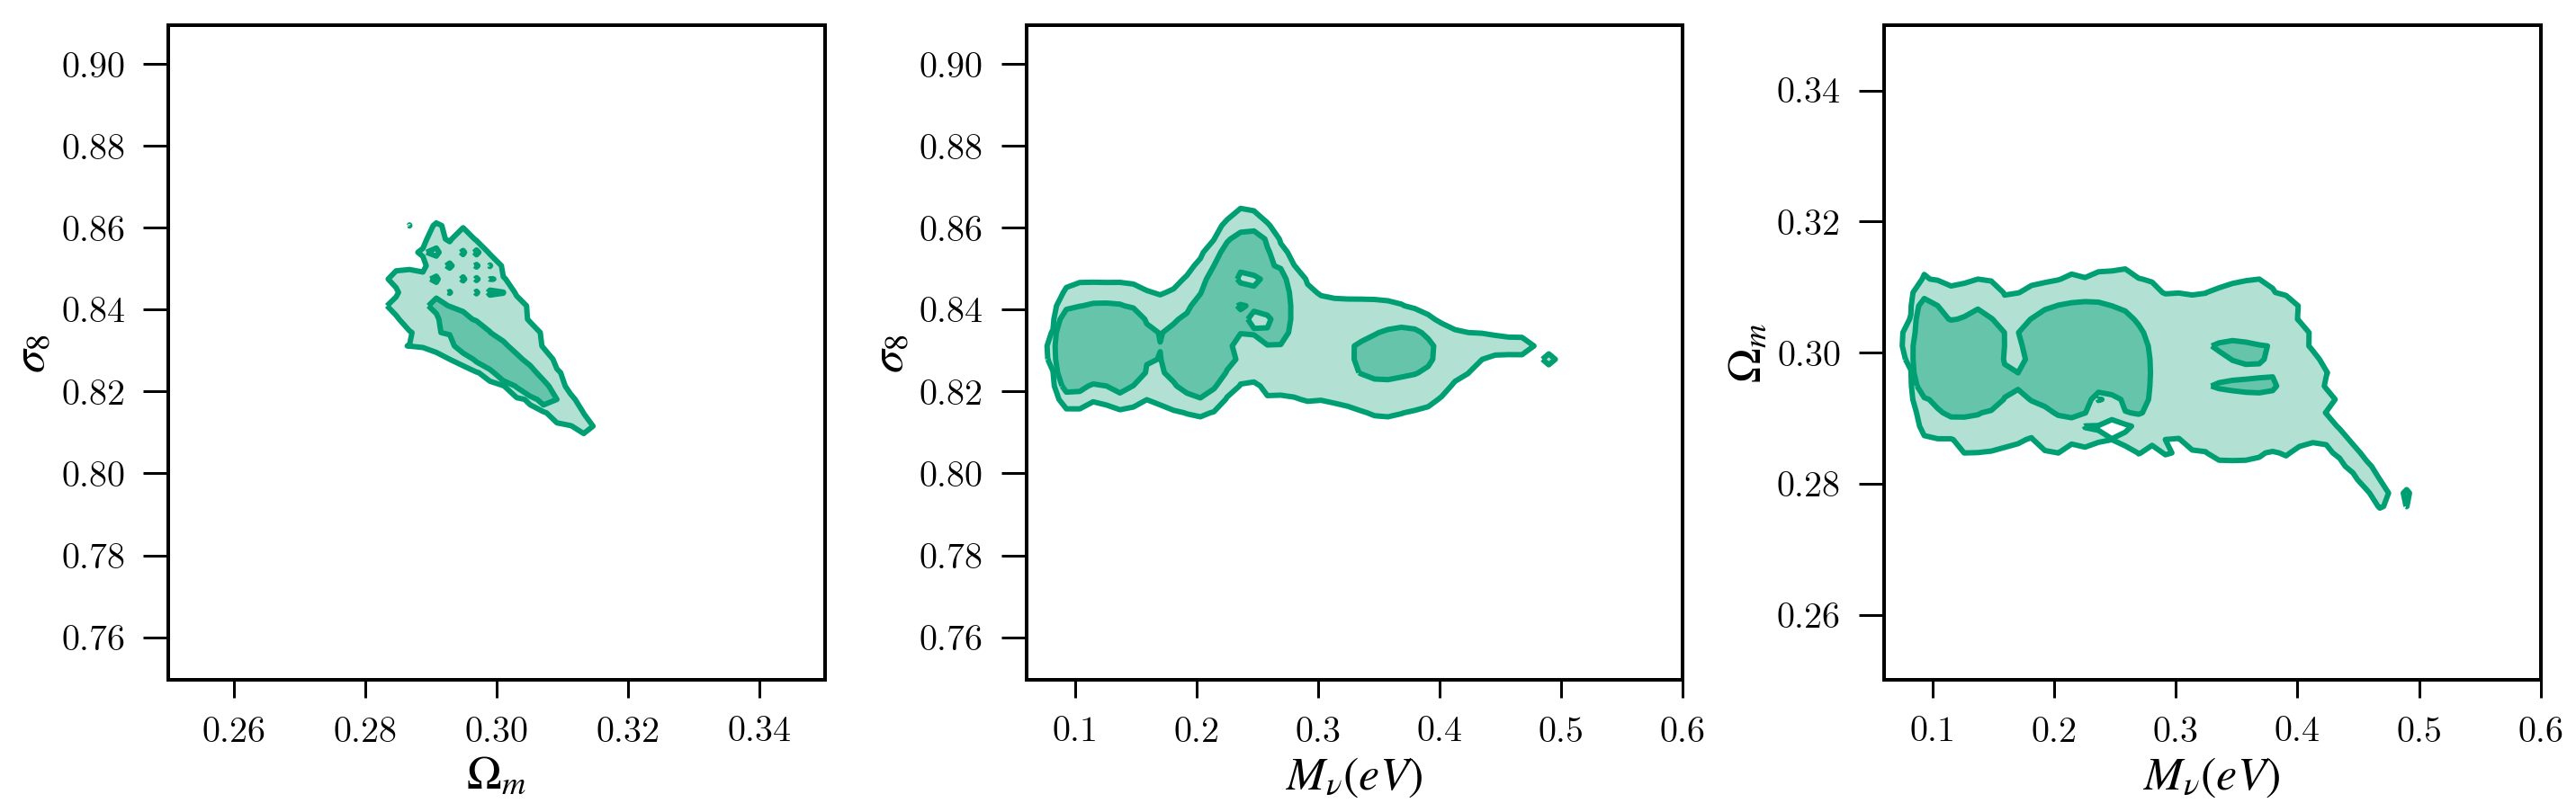

In [19]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/5z_PS_bin50_xyz.npy' )
c2 = np.load( 'cubes/5z_PS_bin50.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[2],
                       input_label='new')
fig.tight_layout()

$\ell_{max} < 10000

## Max Resolution Test
$\ell_{max} < 20000$

In [12]:
%%time
ell, ps_mean = get_meanstack_multiz( 'PS', noisy='K', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])
invcov = get_invcov( 'PS', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=300, bin_max=5000, smoothing='1.00', binscale='log')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[1])

nres = 30
x = np.linspace(0.06, 0.1 + 0.5, nres) # M_nu
y = np.linspace(0.3 - 0.05, 0.3 + 0.05, nres) # omega_m
z = np.linspace(0.8295 - 0.08, 0.8295 + 0.08, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PS_bin50_ell5k.npy', cube)
np.save( 'cubes/5z_PS_bin50_ell5k_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 120 bin 0.9878975795159032 sky 0.001225
CPU times: user 19.7 s, sys: 3.59 s, total: 23.3 s
Wall time: 8min 34s


In [13]:
%%time
ell, ps_mean = get_meanstack_multiz( 'PS', noisy='K', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=300, bin_max=20000, smoothing='1.00', binscale='log' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])
invcov = get_invcov( 'PS', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=300, bin_max=20000, smoothing='1.00', binscale='log')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[1])

nres = 30
x = np.linspace(0.06, 0.1 + 0.5, nres) # M_nu
y = np.linspace(0.3 - 0.05, 0.3 + 0.05, nres) # omega_m
z = np.linspace(0.8295 - 0.08, 0.8295 + 0.08, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PS_bin50_ell20k.npy', cube)
np.save( 'cubes/5z_PS_bin50_ell20k_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 180 bin 0.9818963792758552 sky 0.001225
CPU times: user 23.9 s, sys: 3.66 s, total: 27.6 s
Wall time: 10min 16s


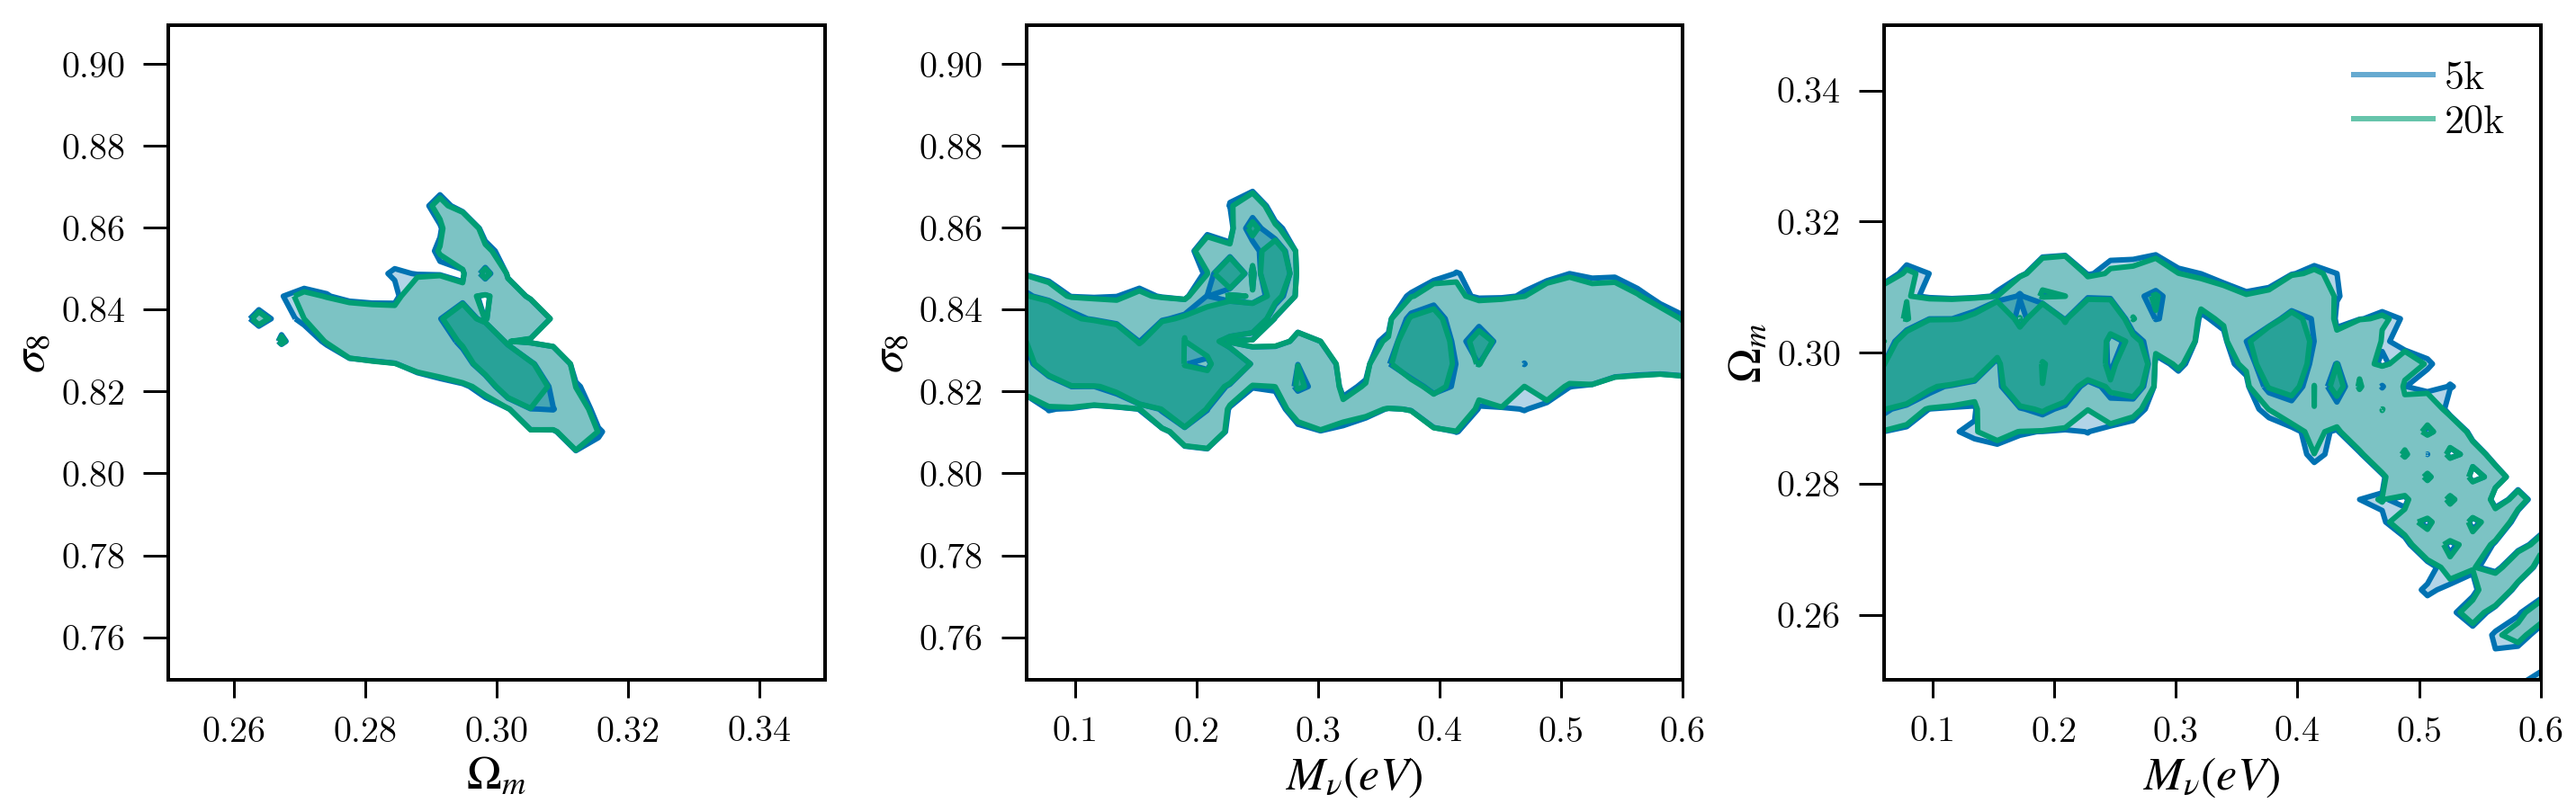

In [16]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/5z_PS_bin50_ell5k_xyz.npy' )
c2 = np.load( 'cubes/5z_PS_bin50_ell5k.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[1],
                       input_label='5k')

x,y,z = np.load(  'cubes/5z_PS_bin50_ell20k_xyz.npy' )
c2 = np.load( 'cubes/5z_PS_bin50_ell20k.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, fig=fig, axes=axes,
                        input_color=default_color_list[2],
                       input_label='20k')

plt.legend()
fig.tight_layout()

# Squares

# Interpolation Test

In [89]:
ll, ps_mean = get_meanstack_multiz( 'PS', noisy='KN', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])
invcov = get_invcov( 'PS', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=300, bin_max=5000, smoothing='1.00', binscale='log')


dist_list = []
stat_list_quad_KS = []
stat_list_linear_KS = []
stat_list_quad_1000 = []
stat_list_linear_1000 = []

for row_to_remove, param_row in enumerate(params.T):
    # remove the row we want to test
    obsarr_without_row = np.delete(ps_mean, row_to_remove, axis=0)
    params_without_row = np.delete(params, row_to_remove, axis=1)
    
    # remove the fiducial value, it will always be 0 so we don't have to worry
    if row_to_remove != 0:
        obsarr_without_row = np.delete(obsarr_without_row, 0, axis=0)
        params_without_row = np.delete(params_without_row, 0, axis=1)
    
    # construct interpolator for PS
    test_interp_ps_quadratic = Interp(obsarr=obsarr_without_row,
                            cosmo_params=params_without_row,
                            invcov=invcov,
                            fiducial_model=ps_mean[1],
                            function='multiquadric')
    test_interp_ps_linear = Interp(obsarr=obsarr_without_row,
                            cosmo_params=params_without_row,
                            invcov=invcov,
                            fiducial_model=ps_mean[1],
                            function='linear')
    ## compute KS stat
    interpolated_value = test_interp_ps_quadratic.interp_func( param_row )
    KS_stat = np.max( np.abs(interpolated_value - ps_mean[row_to_remove])/ps_mean[row_to_remove] )
    stat_list_quad_KS.append(KS_stat)
    stat_list_quad_1000.append( 
        (interpolated_value[10] - ps_mean[row_to_remove][10])/
        ps_mean[row_to_remove][10])
    
    interpolated_value = test_interp_ps_linear.interp_func( param_row )
    KS_stat = np.max( np.abs(interpolated_value - ps_mean[row_to_remove])/ps_mean[row_to_remove] )
    stat_list_linear_KS.append(KS_stat)
    stat_list_linear_1000.append( 
        (interpolated_value[10] - ps_mean[row_to_remove][10])/
        ps_mean[row_to_remove][10])
    
    dist_stat = np.sqrt( np.sum((param_row - params.T[0])**2) )
    dist_list.append(dist_stat)

nr 9999 nb 120 bin 0.9878975795159032 sky 0.001225


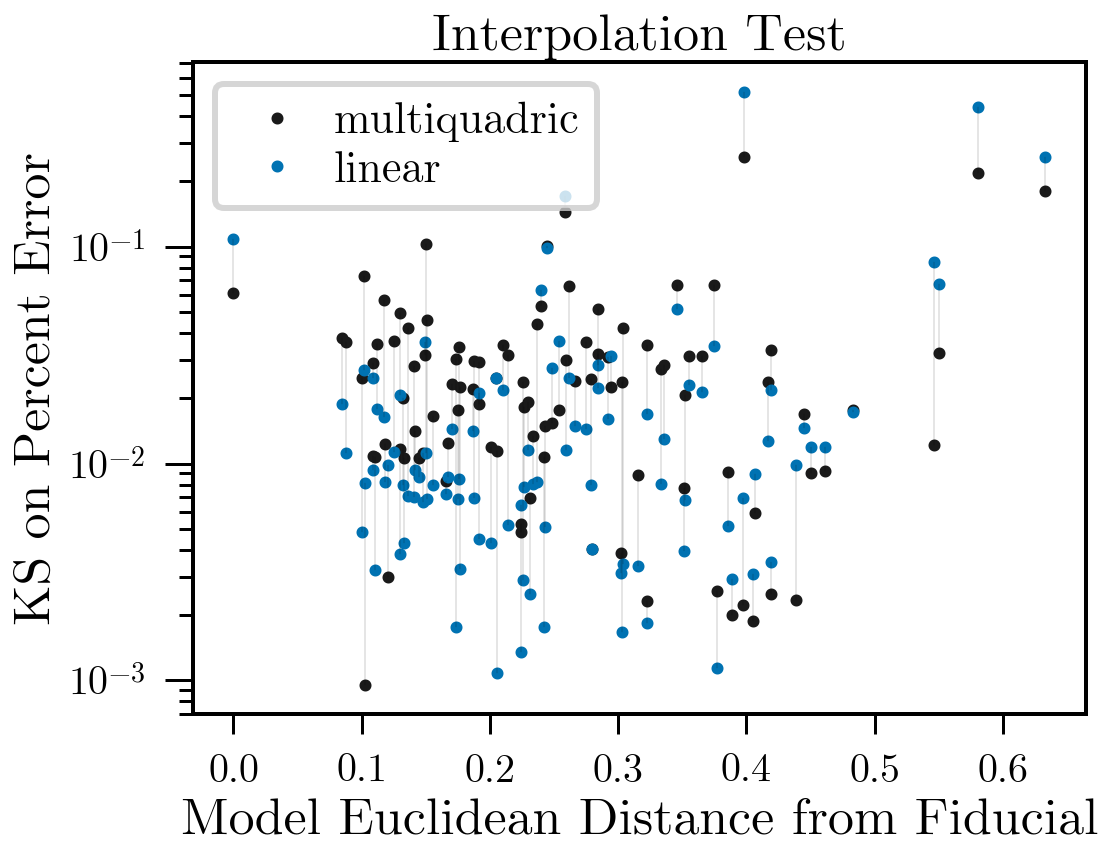

In [84]:
plt.plot( dist_list, stat_list_quad_KS, 'o', label='multiquadric' )
plt.plot( dist_list, stat_list_linear_KS, 'o', label='linear' )

for i, d in enumerate(dist_list):
    plt.plot( [d,d], [stat_list_quad[i], stat_list_linear[i]], 'k-', lw=0.1 )

plt.xlabel('Model Euclidean Distance from Fiducial')
plt.ylabel('KS on Percent Error')
plt.title('Interpolation Test')
plt.yscale('log')
plt.legend(frameon=True)


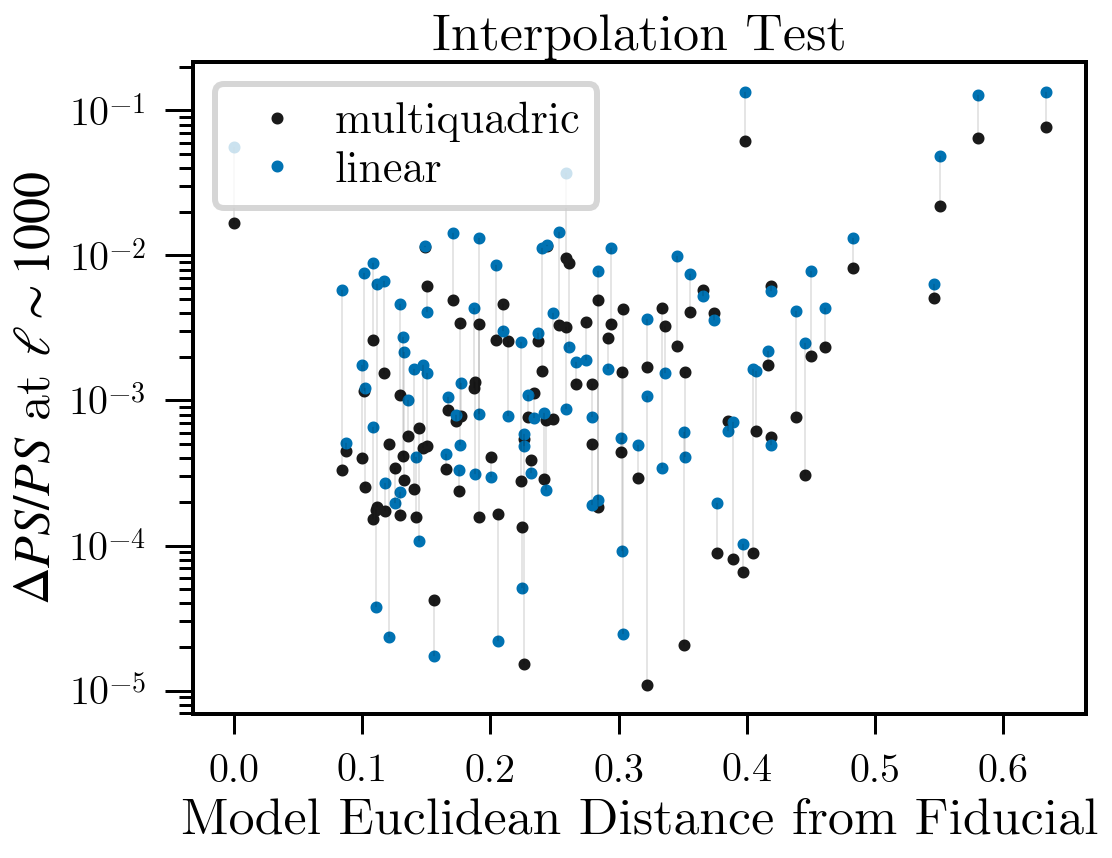

In [95]:
plt.plot( dist_list, np.abs(stat_list_quad_1000), 'o', label='multiquadric' )
plt.plot( dist_list, np.abs(stat_list_linear_1000), 'o', label='linear' )

for i, d in enumerate(dist_list):
    plt.plot( [d,d], [np.abs(stat_list_quad_1000[i]), 
                      np.abs(stat_list_linear_1000[i])], 'k-', lw=0.1 )

plt.xlabel('Model Euclidean Distance from Fiducial')
plt.ylabel('$\Delta PS / PS$ at $\ell \sim 1000$')
plt.title('Interpolation Test')
plt.legend(frameon=True)
plt.yscale('log')

Text(0.5,0,'Model Euclidean Distance from Fiducial')

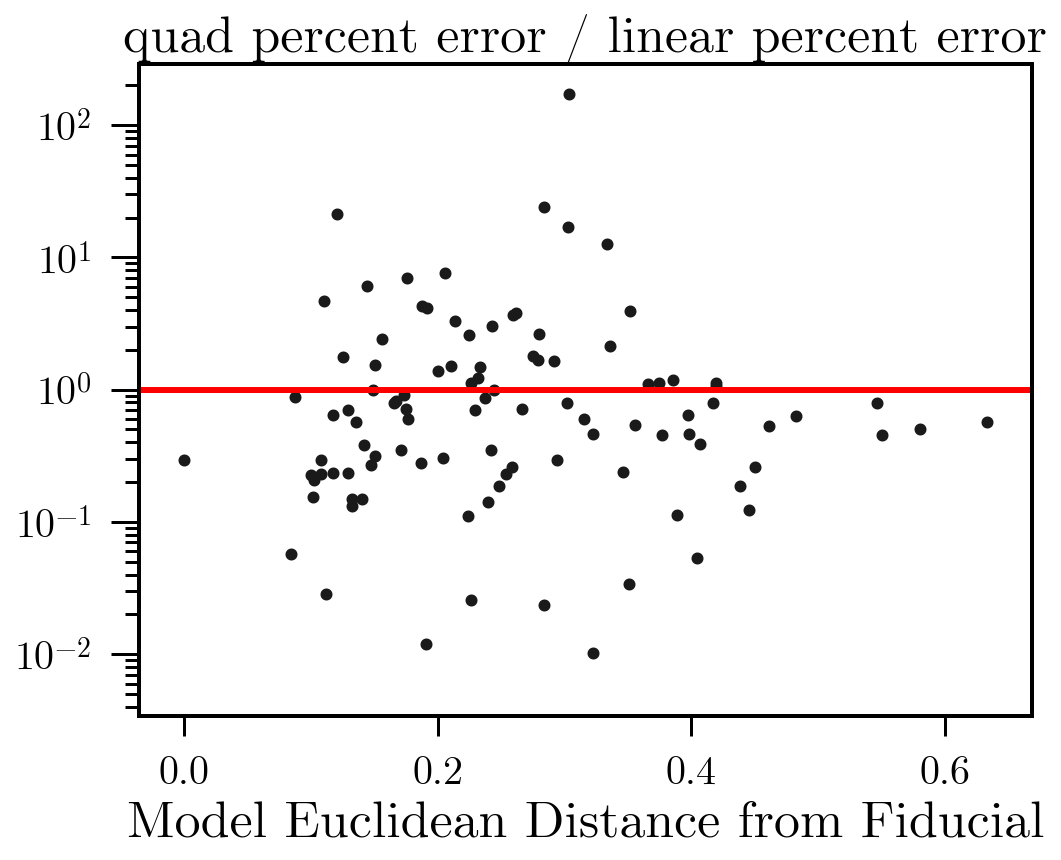

In [99]:
plt.scatter( dist_list, np.abs(np.array(stat_list_quad_1000)/np.array(stat_list_linear_1000)) )
plt.yscale('log')
plt.axhline(1, color='r')
plt.title('quad percent error / linear percent error')
plt.xlabel('Model Euclidean Distance from Fiducial')

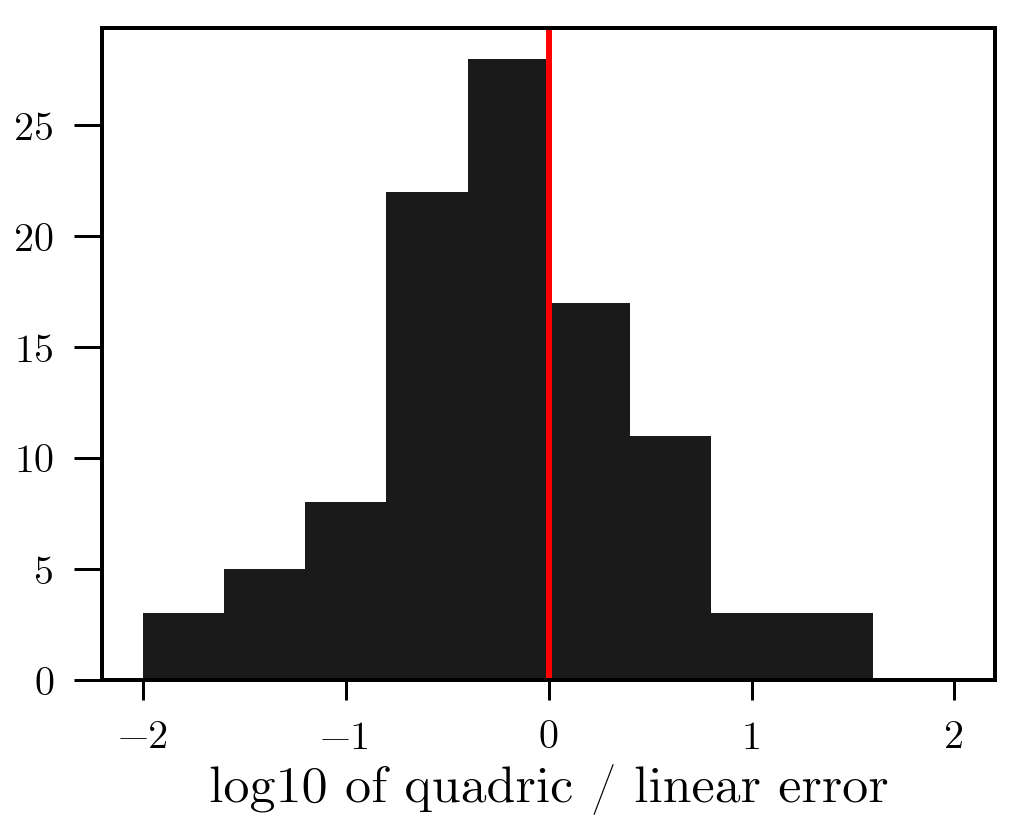

In [107]:
plt.hist( np.log10(np.abs(np.array(stat_list_quad_1000)/np.array(stat_list_linear_1000)) ) 
        ,bins = 10, range=(-2,2) )
plt.xlabel('log10 of quadric / linear error')
plt.axvline(0, color='red')

# Large Plots 

## PS 5 redshift

$A_s$ goes like 0.1
$\sigma_8$ goes like 0.04

## NOISY COV - NOISE EMU

In [128]:
%%time
ell, ps_mean = get_meanstack_multiz( 'PS', noisy='KN', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'PS', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=300, bin_max=5000, smoothing='1.00', binscale='log')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

nres = 30
x = np.linspace(0.06, 0.1 + 0.4, nres) # M_nu
y = np.linspace(0.3 - 0.03, 0.3 + 0.03, nres) # omega_m
z = np.linspace(0.8295 - 0.04, 0.8295 + 0.04, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PS_bin50.npy', cube)
np.save( 'cubes/5z_PS_bin50_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 120 bin 0.9878975795159032 sky 0.001225
CPU times: user 17.7 s, sys: 4.21 s, total: 21.9 s
Wall time: 8min 39s


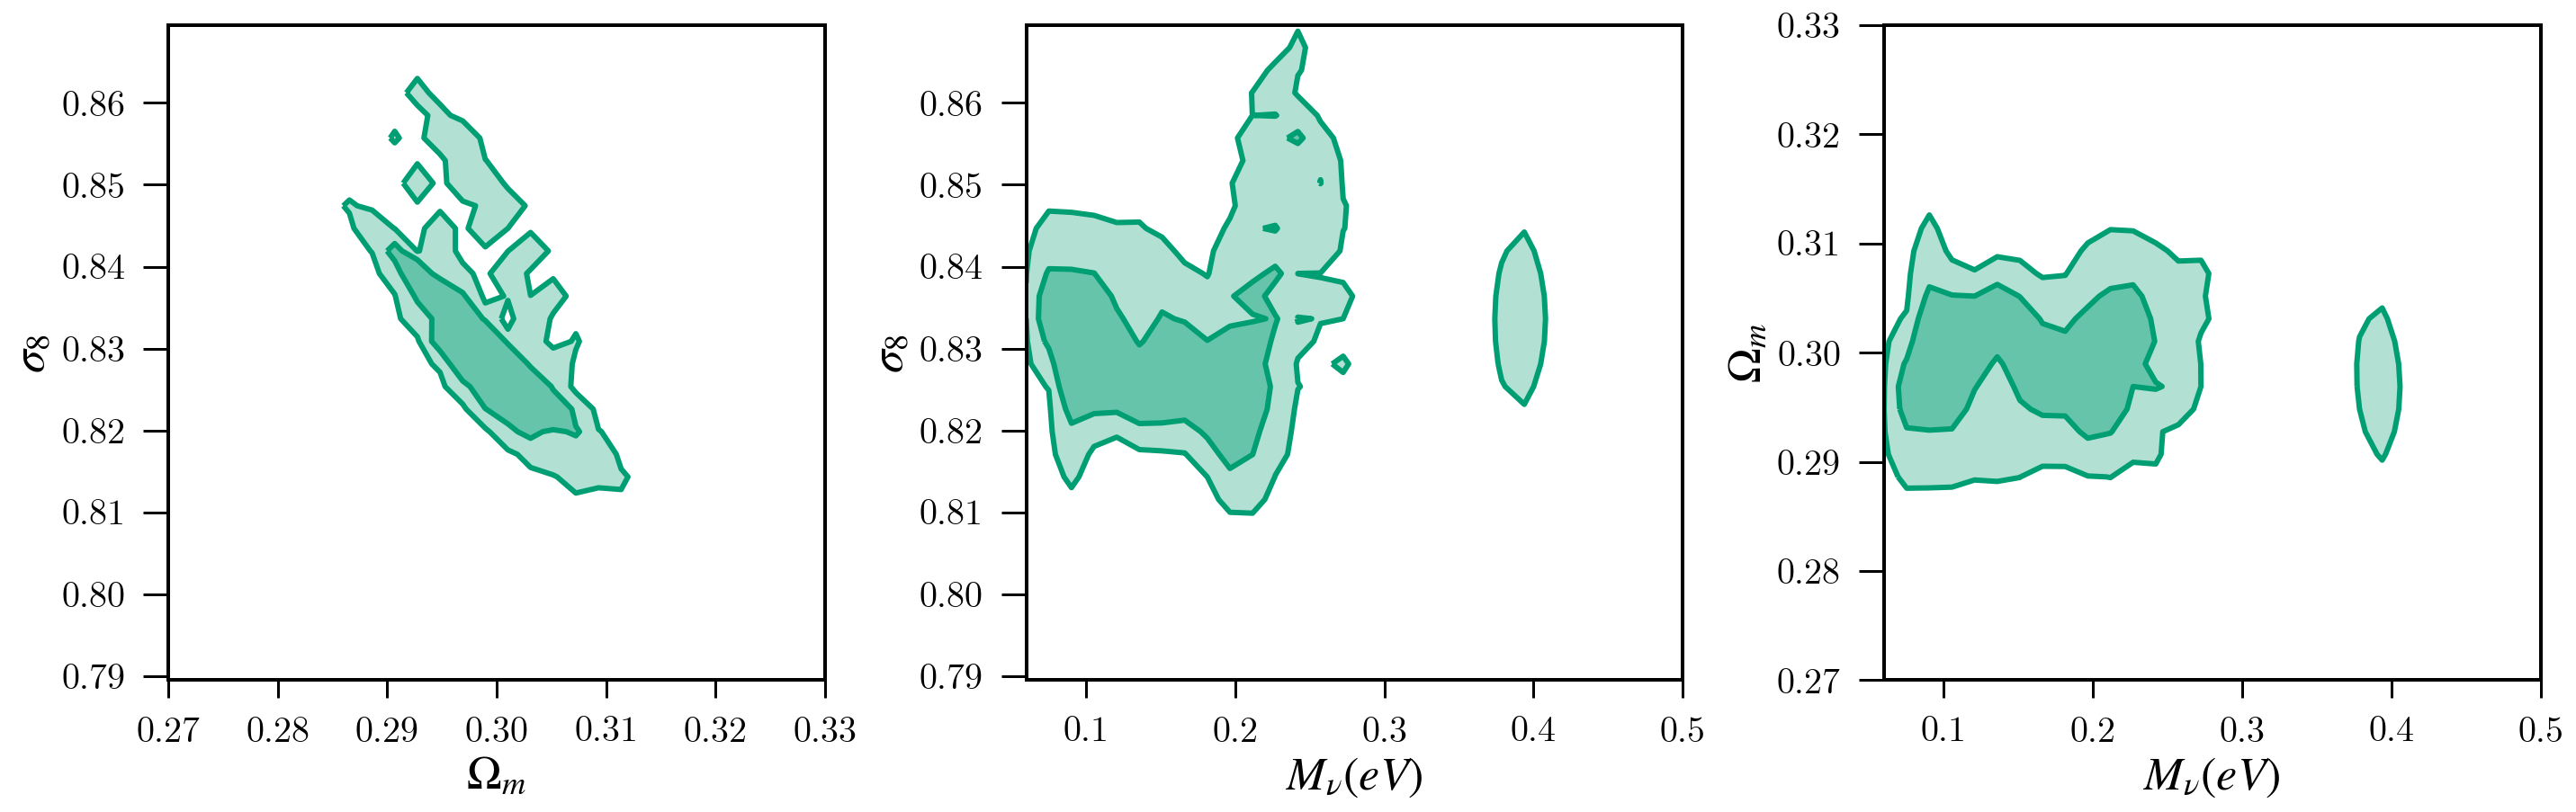

In [129]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/5z_PS_bin50_xyz.npy' )
c2 = np.load( 'cubes/5z_PS_bin50.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[2],
                       input_label='new')
fig.tight_layout()

## Noiseless Cov - Noiseless EMU

In [135]:
%%time
ell, ps_mean = get_meanstack_multiz( 'PS', noisy='K', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'PS', noisy='K', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=300, bin_max=5000, smoothing='1.00', binscale='log')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

nres = 30
x = np.linspace(0.06, 0.1 + 0.1, nres) # M_nu
y = np.linspace(0.3 - 0.01, 0.3 + 0.01, nres) # omega_m
z = np.linspace(0.8295 - 0.01, 0.8295 + 0.01, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PS_bin50_eKcK.npy', cube)
np.save( 'cubes/5z_PS_bin50_eKcK_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 120 bin 0.9878975795159032 sky 0.001225
CPU times: user 17.4 s, sys: 3.11 s, total: 20.5 s
Wall time: 7min 2s


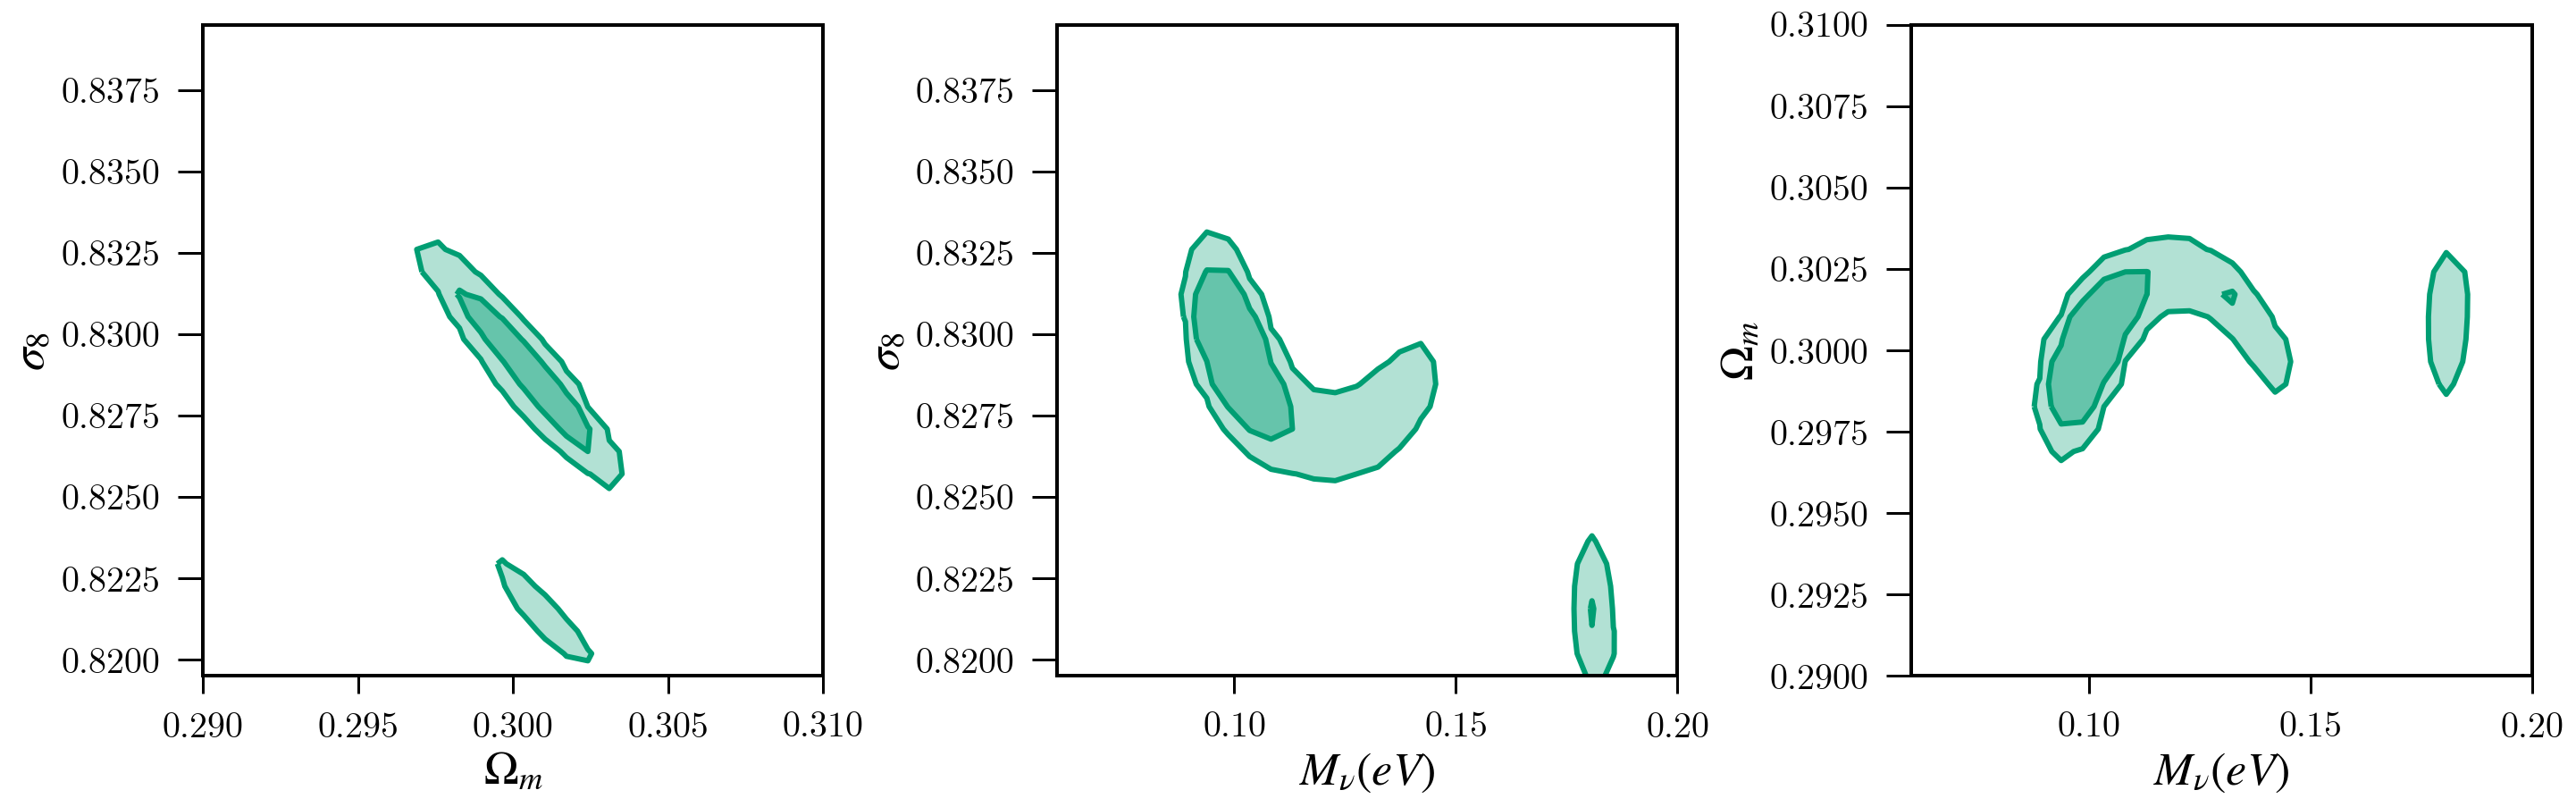

In [136]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/5z_PS_bin50_eKcK_xyz.npy' )
c2 = np.load( 'cubes/5z_PS_bin50_eKcK.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[2],
                       input_label='new')
fig.tight_layout()

### Now with 5000 realizations

In [202]:
%%time
ell, ps_mean = get_meanstack_multiz( 'PS', noisy='K', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log', max_realizations=5000 )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'PS', noisy='K', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=300, bin_max=5000, smoothing='1.00', binscale='log')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

nres = 30
x = np.linspace(0.06, 0.1 + 0.1, nres) # M_nu
y = np.linspace(0.3 - 0.01, 0.3 + 0.01, nres) # omega_m
z = np.linspace(0.8295 - 0.01, 0.8295 + 0.01, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PS_bin50_eKcK_nr5000.npy', cube)
np.save( 'cubes/5z_PS_bin50_eKcK_xyz_nr5000.npy', np.array([x,y,z]) )

nr 9999 nb 120 bin 0.9878975795159032 sky 0.001225
CPU times: user 18.3 s, sys: 4.03 s, total: 22.3 s
Wall time: 8min 45s


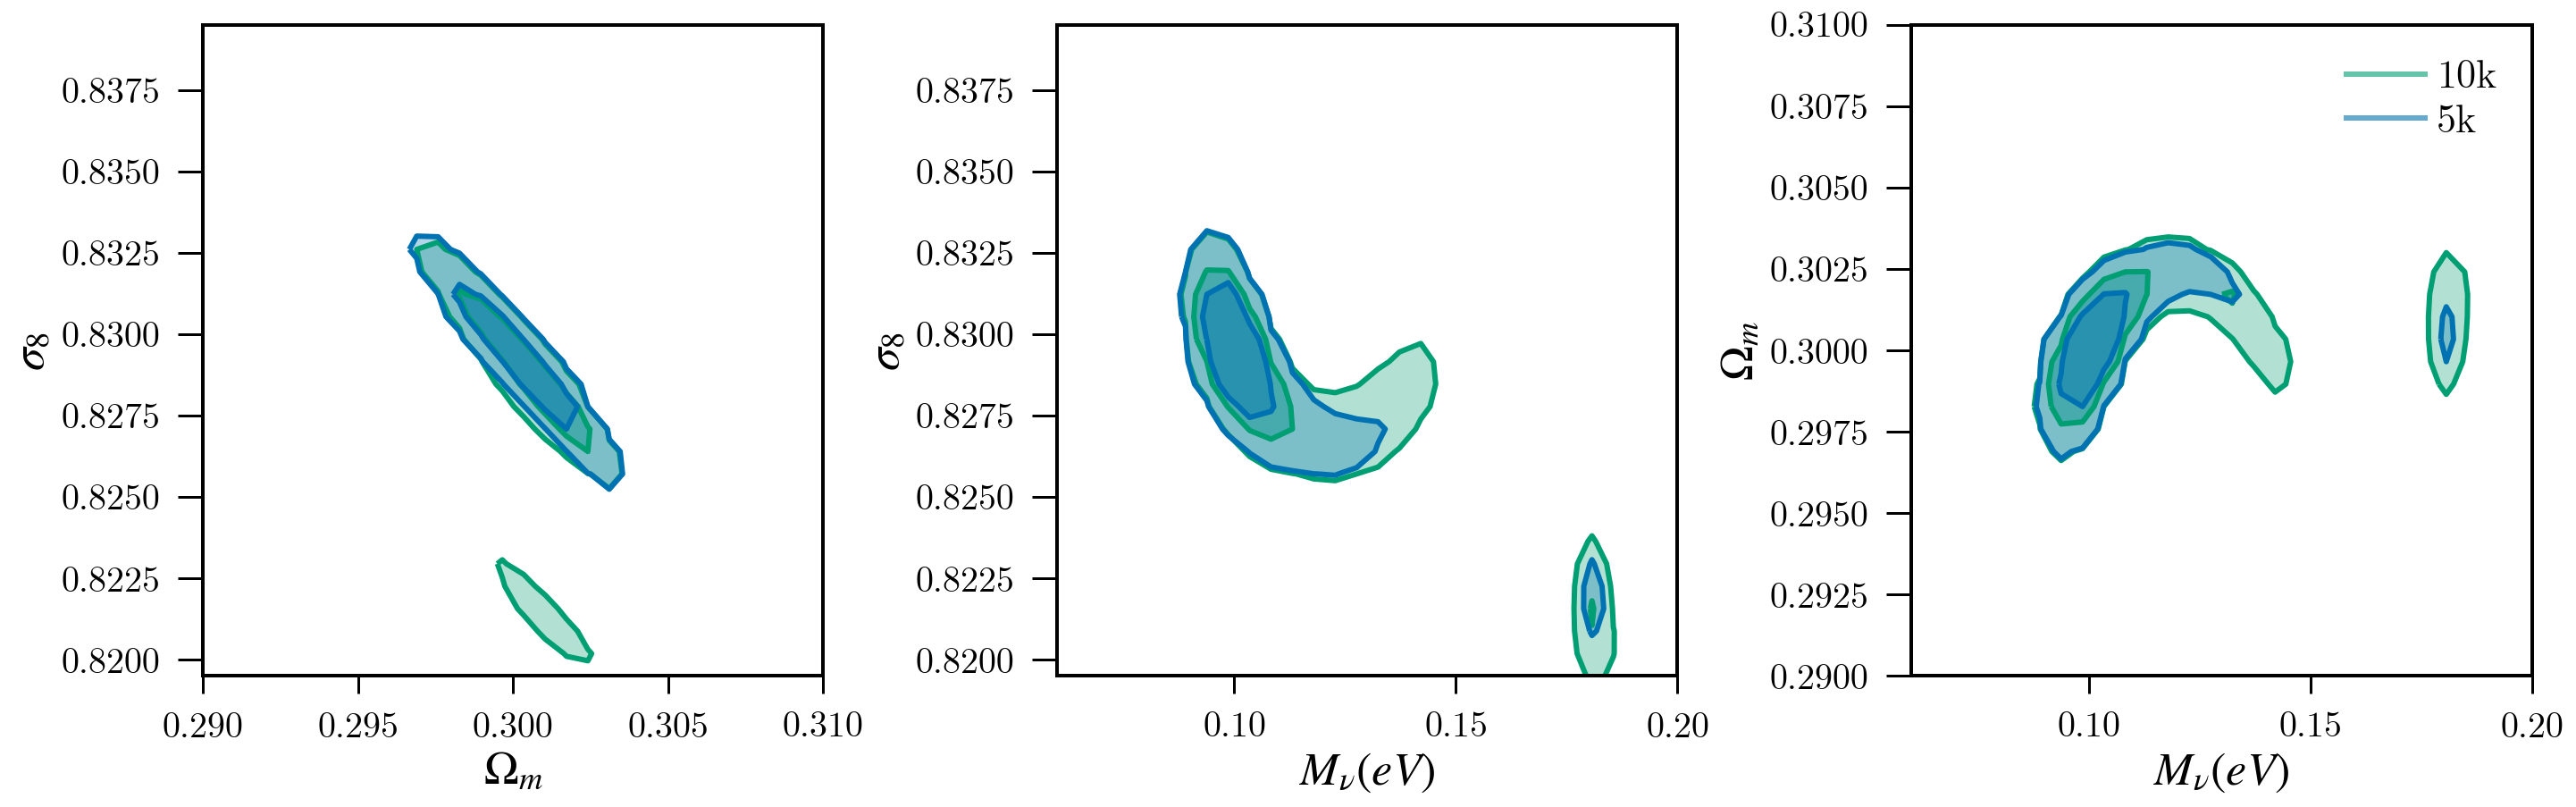

In [204]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/5z_PS_bin50_eKcK_xyz.npy' )
c2 = np.load( 'cubes/5z_PS_bin50_eKcK.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[2],
                       input_label='10k')

x,y,z = np.load(  'cubes/5z_PS_bin50_eKcK_xyz_nr5000.npy' )
c2 = np.load( 'cubes/5z_PS_bin50_eKcK_nr5000.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fig=fig, axes=axes, fill=True, 
                        input_color=default_color_list[1],
                       input_label='5k')
fig.tight_layout()
plt.legend()

## Noisy Cov - Noiseless Emulator

In [218]:
%%time
ell, ps_mean = get_meanstack_multiz( 'PS', noisy='K', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'PS', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=300, bin_max=5000, smoothing='1.00', binscale='log')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

nres = 30
x = np.linspace(0.06, 0.1 + 0.5, nres) # M_nu
y = np.linspace(0.3 - 0.05, 0.3 + 0.05, nres) # omega_m
z = np.linspace(0.8295 - 0.05, 0.8295 + 0.05, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PS_bin50_eKNcK.npy', cube)
np.save( 'cubes/5z_PS_bin50_eKNcK_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 120 bin 0.9878975795159032 sky 0.001225
CPU times: user 20.4 s, sys: 5.12 s, total: 25.5 s
Wall time: 7min 38s


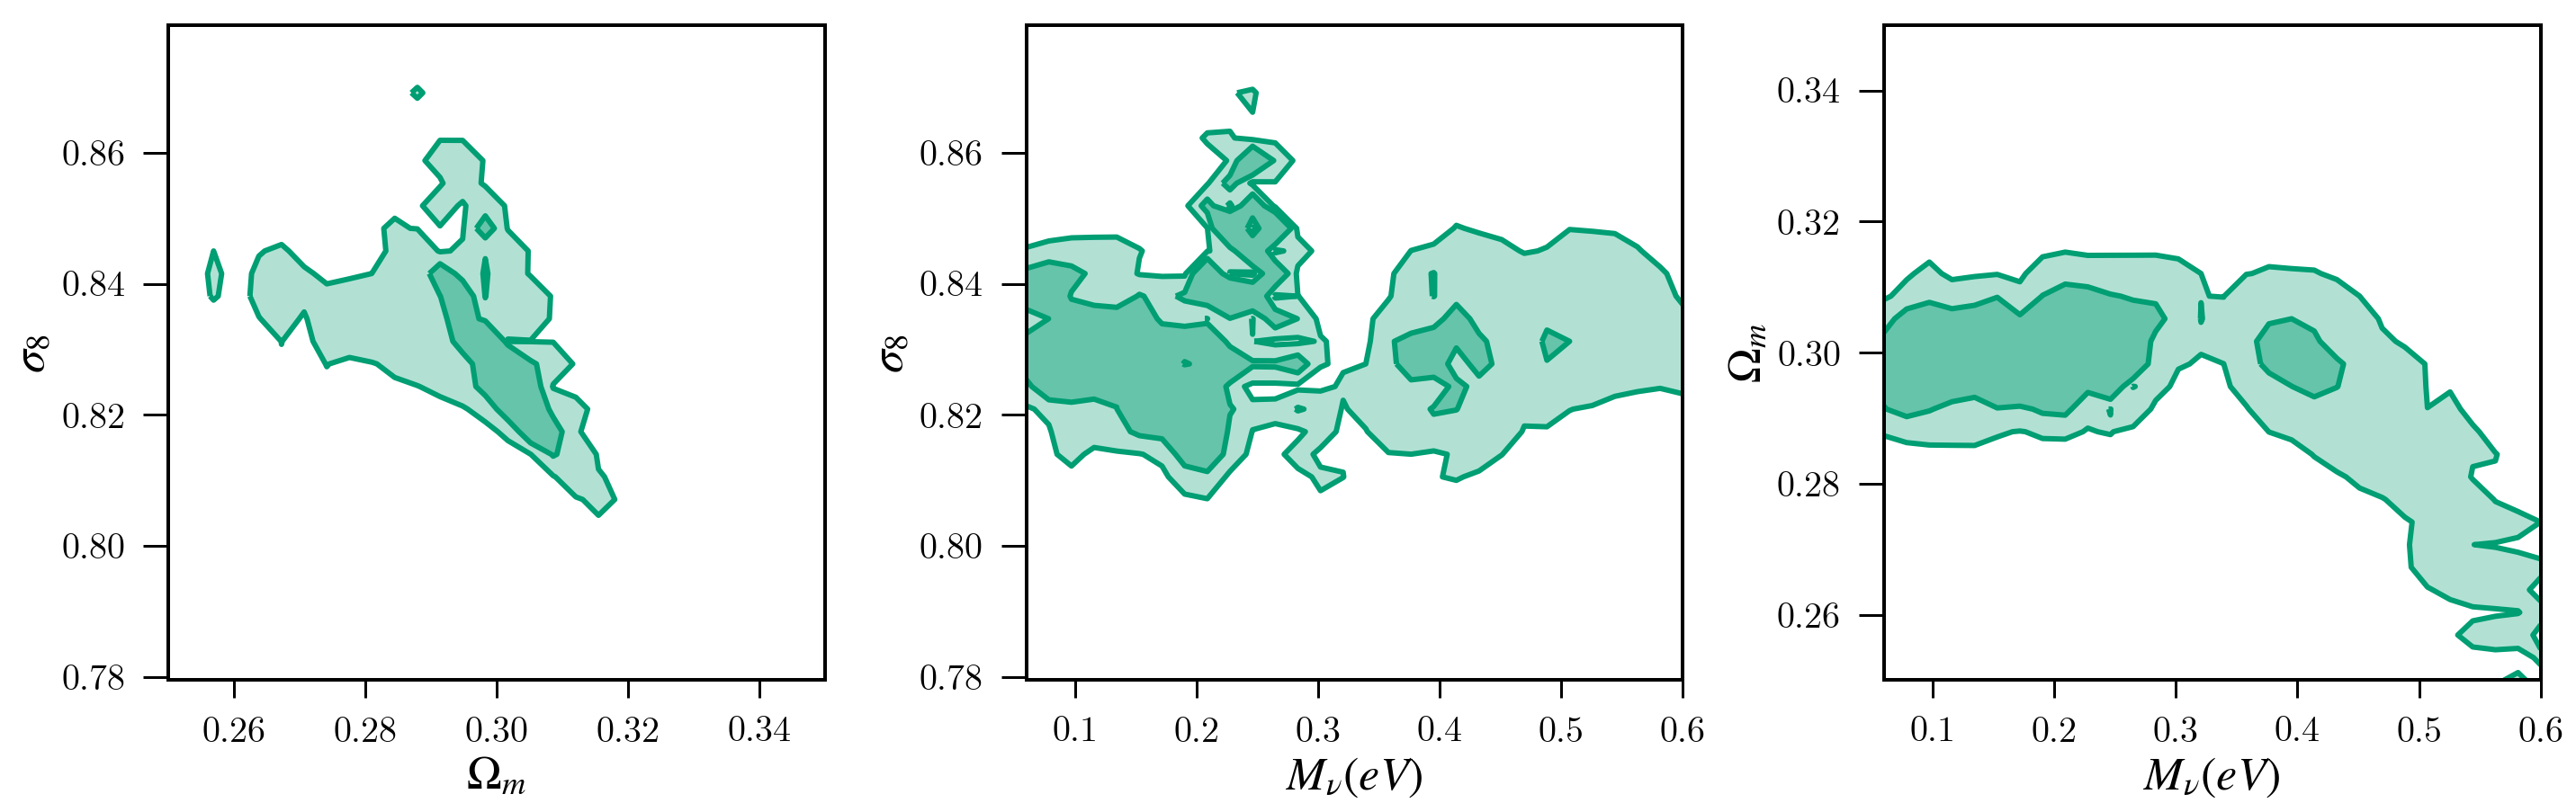

In [219]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/5z_PS_bin50_eKNcK_xyz.npy' )
c2 = np.load( 'cubes/5z_PS_bin50_eKNcK.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[2],
                       input_label='new')
fig.tight_layout()

## ng40

In [223]:
%%time
ell, ps_mean = get_meanstack_multiz( 'PS', noisy='K', redshifts=['10_ng40'],  
                               bin_min=300, bin_max=5000, smoothing='1.00', binscale='log' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'PS', noisy='KN', redshifts=['10_ng40'], 
                                   bin_min=300, bin_max=5000, smoothing='1.00', binscale='log')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

nres = 50
x = np.linspace(0.06, 0.1 + 0.5, nres) # M_nu
y = np.linspace(0.3 - 0.05, 0.3 + 0.05, nres) # omega_m
z = np.linspace(0.8295 - 0.05, 0.8295 + 0.05, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/ng40_PS_bin50_eKNcK.npy', cube)
np.save( 'cubes/ng40_PS_bin50_eKNcK_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 24 bin 0.99749949989998 sky 0.001225
CPU times: user 2min 10s, sys: 4.56 s, total: 2min 14s
Wall time: 2min 39s


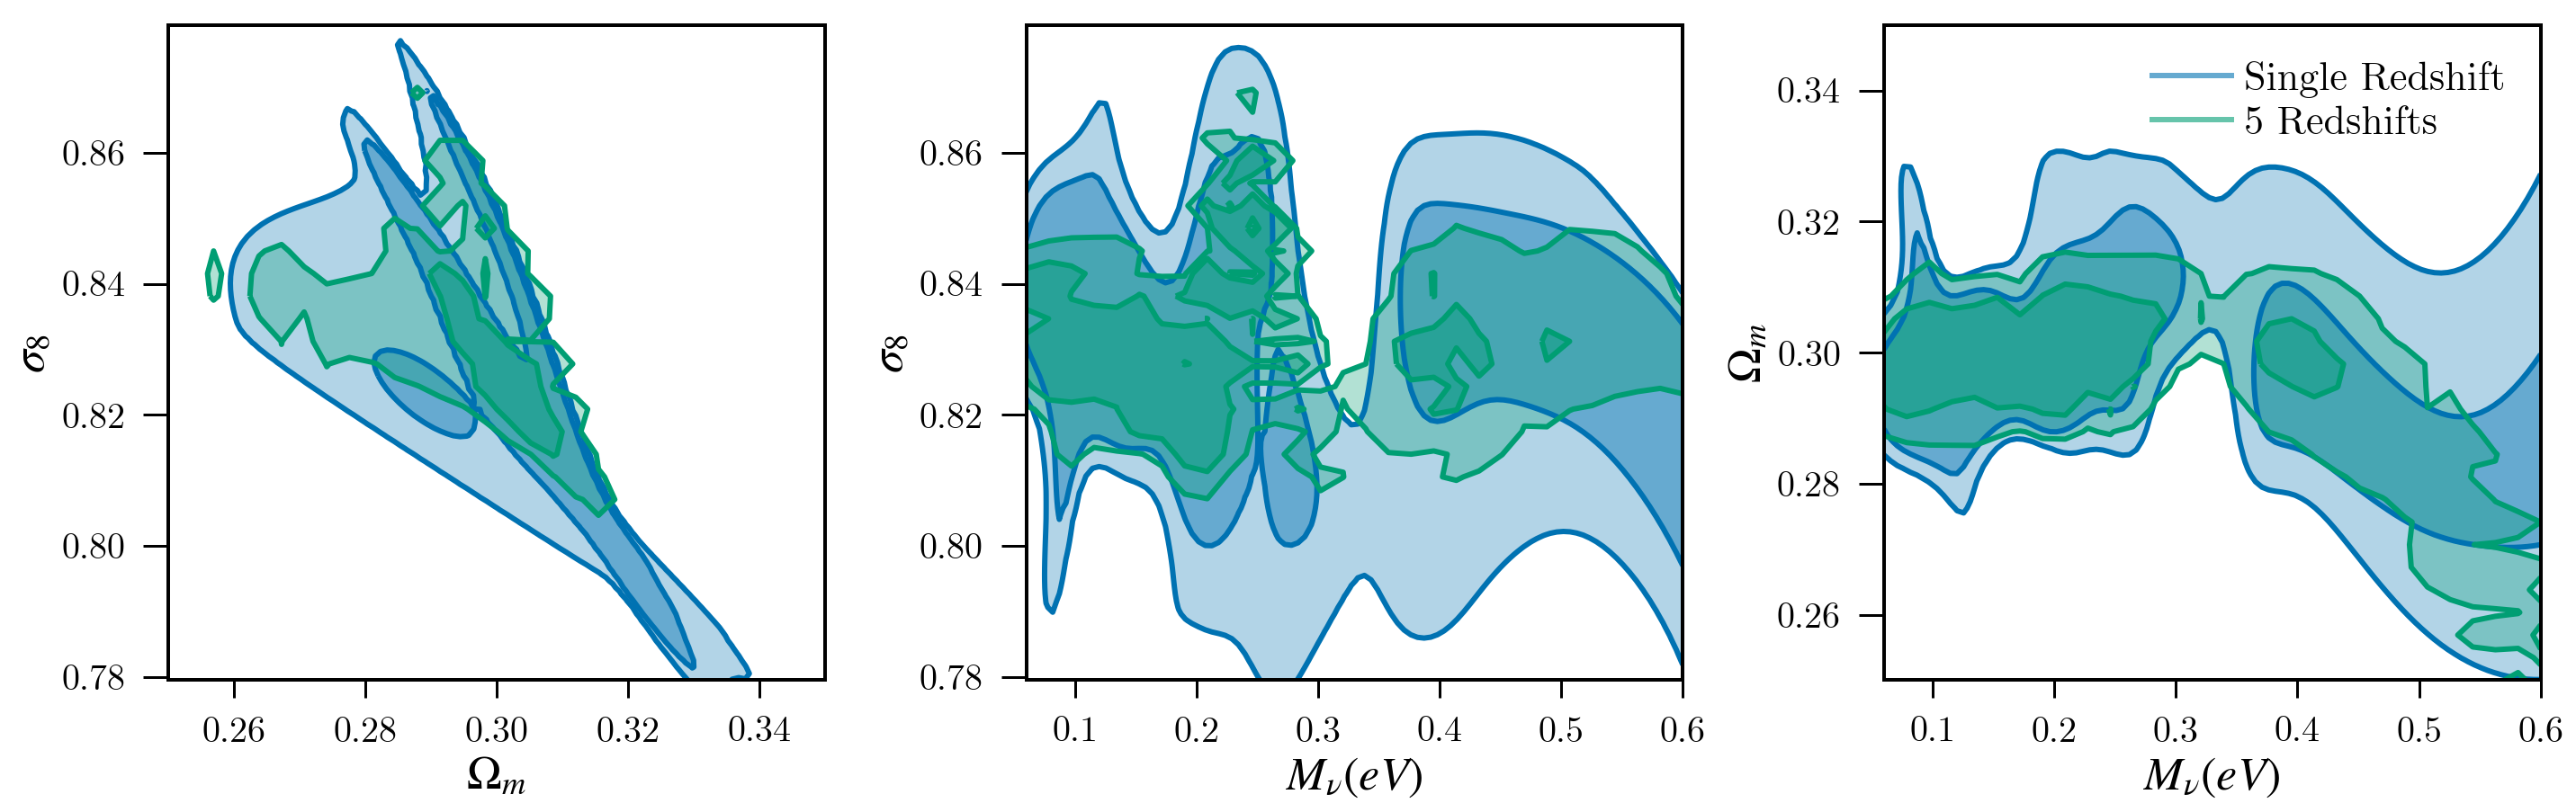

In [244]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/ng40_PS_bin50_eKNcK_xyz.npy' )
c2 = np.load( 'cubes/ng40_PS_bin50_eKNcK.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z],  fill=True, 
                        input_color=default_color_list[1],
                       input_label='Single Redshift')

x,y,z = np.load(  'cubes/5z_PS_bin50_eKNcK_xyz.npy' )
c2 = np.load( 'cubes/5z_PS_bin50_eKNcK.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fig=fig, axes=axes,fill=True, 
                        input_color=default_color_list[2],
                       input_label='5 Redshifts')

plt.legend()
fig.tight_layout()

# Peaks

##  noisy means

In [229]:
%%time
ell, ps_mean = get_meanstack_multiz( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=-0.05, bin_max=100, smoothing='1.00' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=-0.05, bin_max=100, smoothing='1.00')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

nres = 30
x = np.linspace(0.06, 0.1 + 0.5, nres) # M_nu
y = np.linspace(0.3 - 0.05, 0.3 + 0.05, nres) # omega_m
z = np.linspace(0.8295 - 0.05, 0.8295 + 0.05, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PC_bin50_eKNcKN.npy', cube)
np.save( 'cubes/5z_PC_bin50_eKNcKN_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 234 bin 0.9764952990598119 sky 0.001225
CPU times: user 3min 8s, sys: 47.2 s, total: 3min 55s
Wall time: 14min 10s


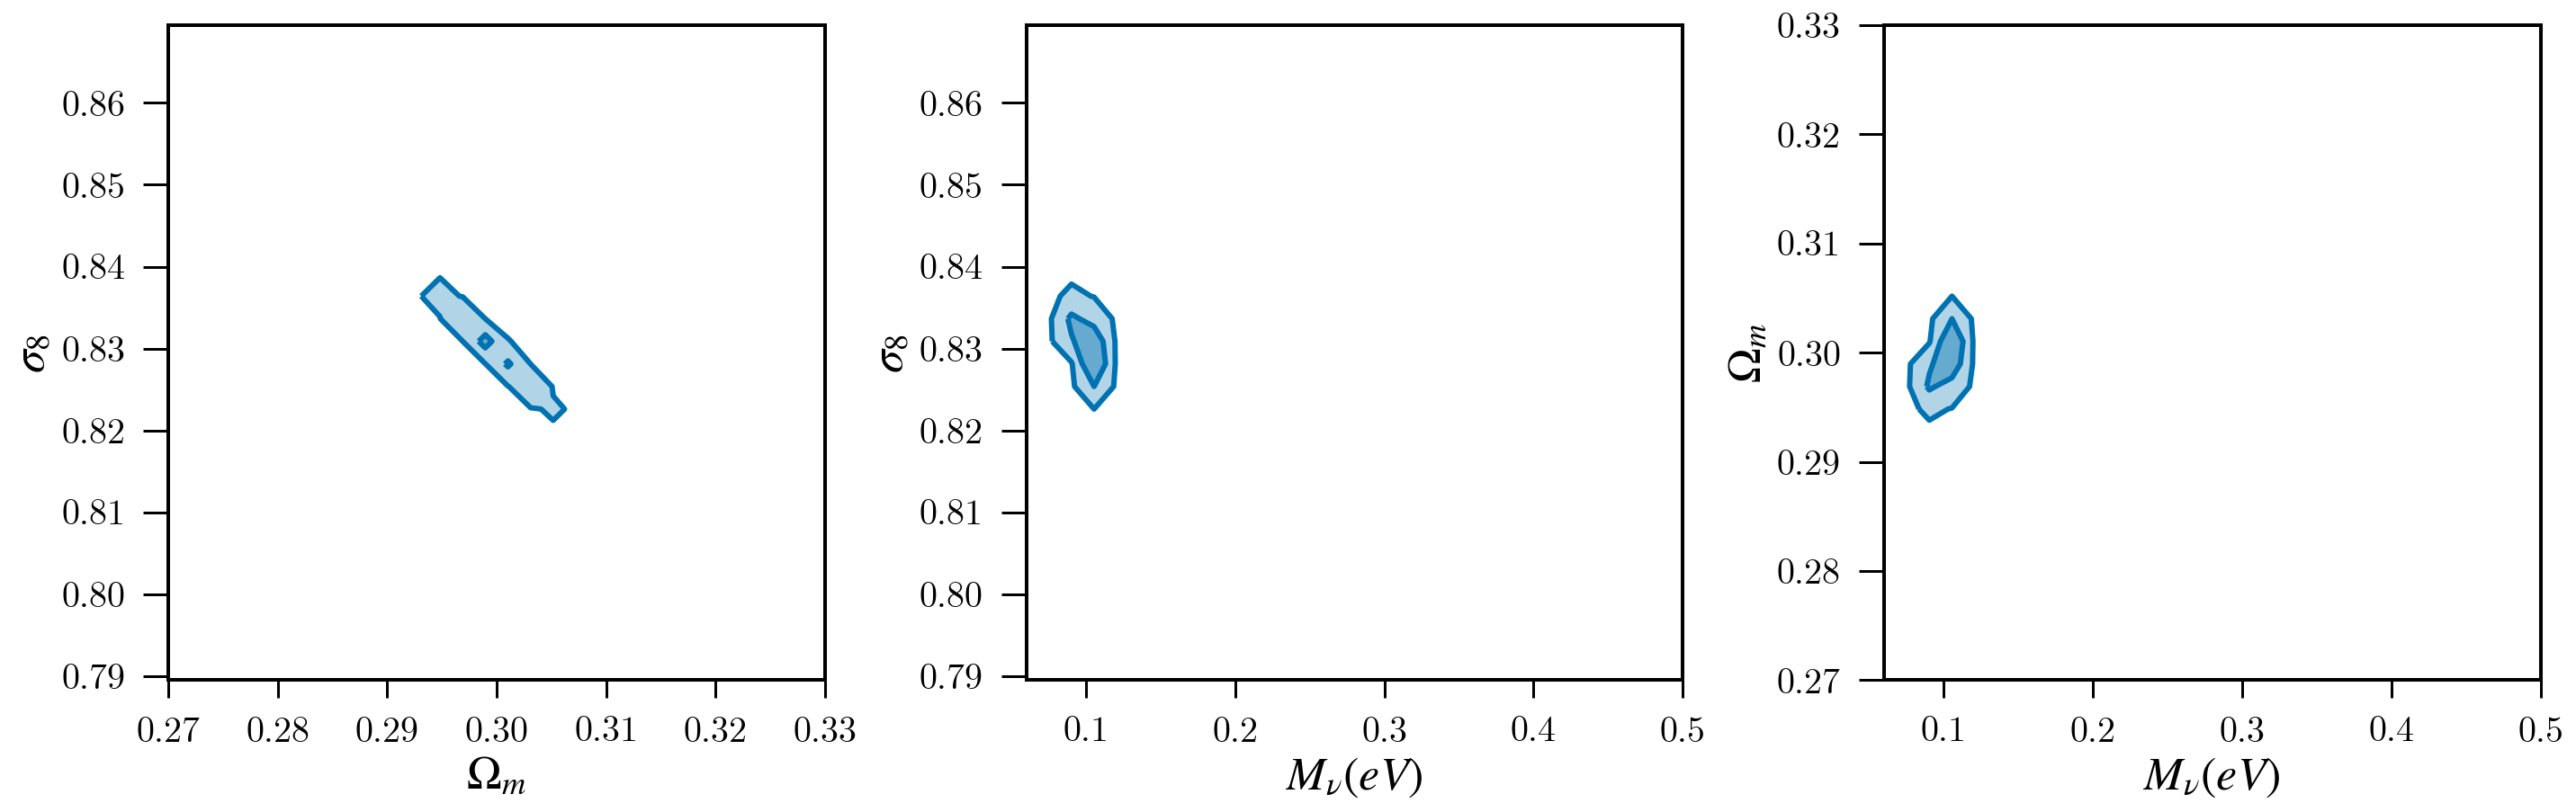

In [230]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/5z_Peaks_bin50_xyz.npy' )
c2 = np.load( 'cubes/5z_Peaks_bin50.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[1],
                       input_label='new')
fig.tight_layout()

In [240]:
%%time
ell, ps_mean = get_meanstack_multiz( 'Peaks', noisy='K', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=-0.05, bin_max=100, smoothing='1.00' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=-0.05, bin_max=100, smoothing='1.00')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

nres = 30
x = np.linspace(0.06, 0.1 + 0.1, nres) # M_nu
y = np.linspace(0.3 - 0.02, 0.3 + 0.02, nres) # omega_m
z = np.linspace(0.8295 - 0.02, 0.8295 + 0.02, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PC_bin50_eKcKN.npy', cube)
np.save( 'cubes/5z_PC_bin50_eKcKN_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 234 bin 0.9764952990598119 sky 0.001225
CPU times: user 25.1 s, sys: 4.6 s, total: 29.7 s
Wall time: 9min 46s


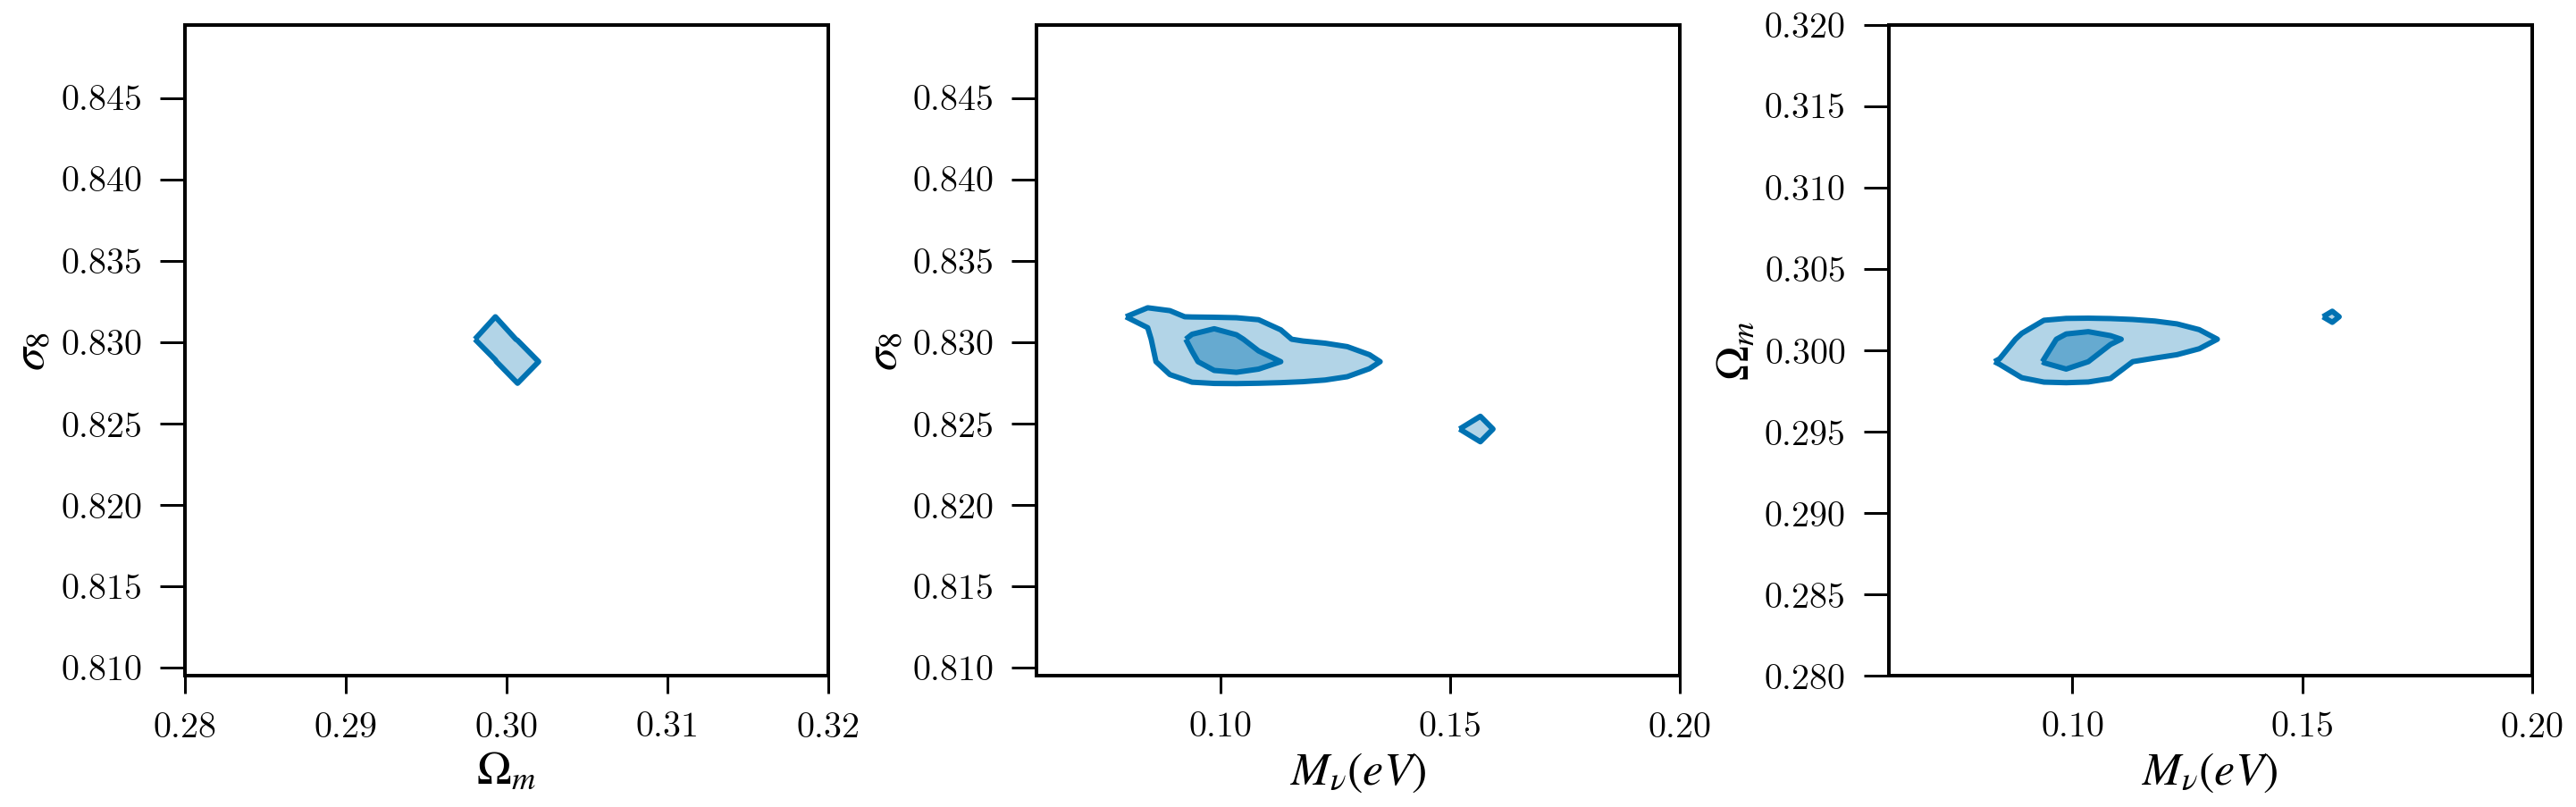

In [242]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/5z_PC_bin50_eKcKN_xyz.npy' )
c2 = np.load( 'cubes/5z_PC_bin50_eKcKN.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[1],
                       input_label='new')
fig.tight_layout()

## ngal40 contour

In [235]:
%%time
ell, ps_mean = get_meanstack_multiz( 'Peaks', noisy='KN', redshifts=['10_ng40'],  
                               bin_min=-0.05, bin_max=100, smoothing='1.00' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'Peaks', noisy='KN', redshifts=['10_ng40'], 
                                   bin_min=-0.05, bin_max=100, smoothing='1.00')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

nres = 50
x = np.linspace(0.06, 0.1 + 0.5, nres) # M_nu
y = np.linspace(0.3 - 0.03, 0.3 + 0.03, nres) # omega_m
z = np.linspace(0.8295 - 0.05, 0.8295 + 0.05, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/ng40_PC_bin50_eKNcKN.npy', cube)
np.save( 'cubes/ng40_PC_bin50_eKNcKN_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 50 bin 0.9948989797959592 sky 0.001225
CPU times: user 22.2 s, sys: 3.29 s, total: 25.5 s
Wall time: 36.7 s


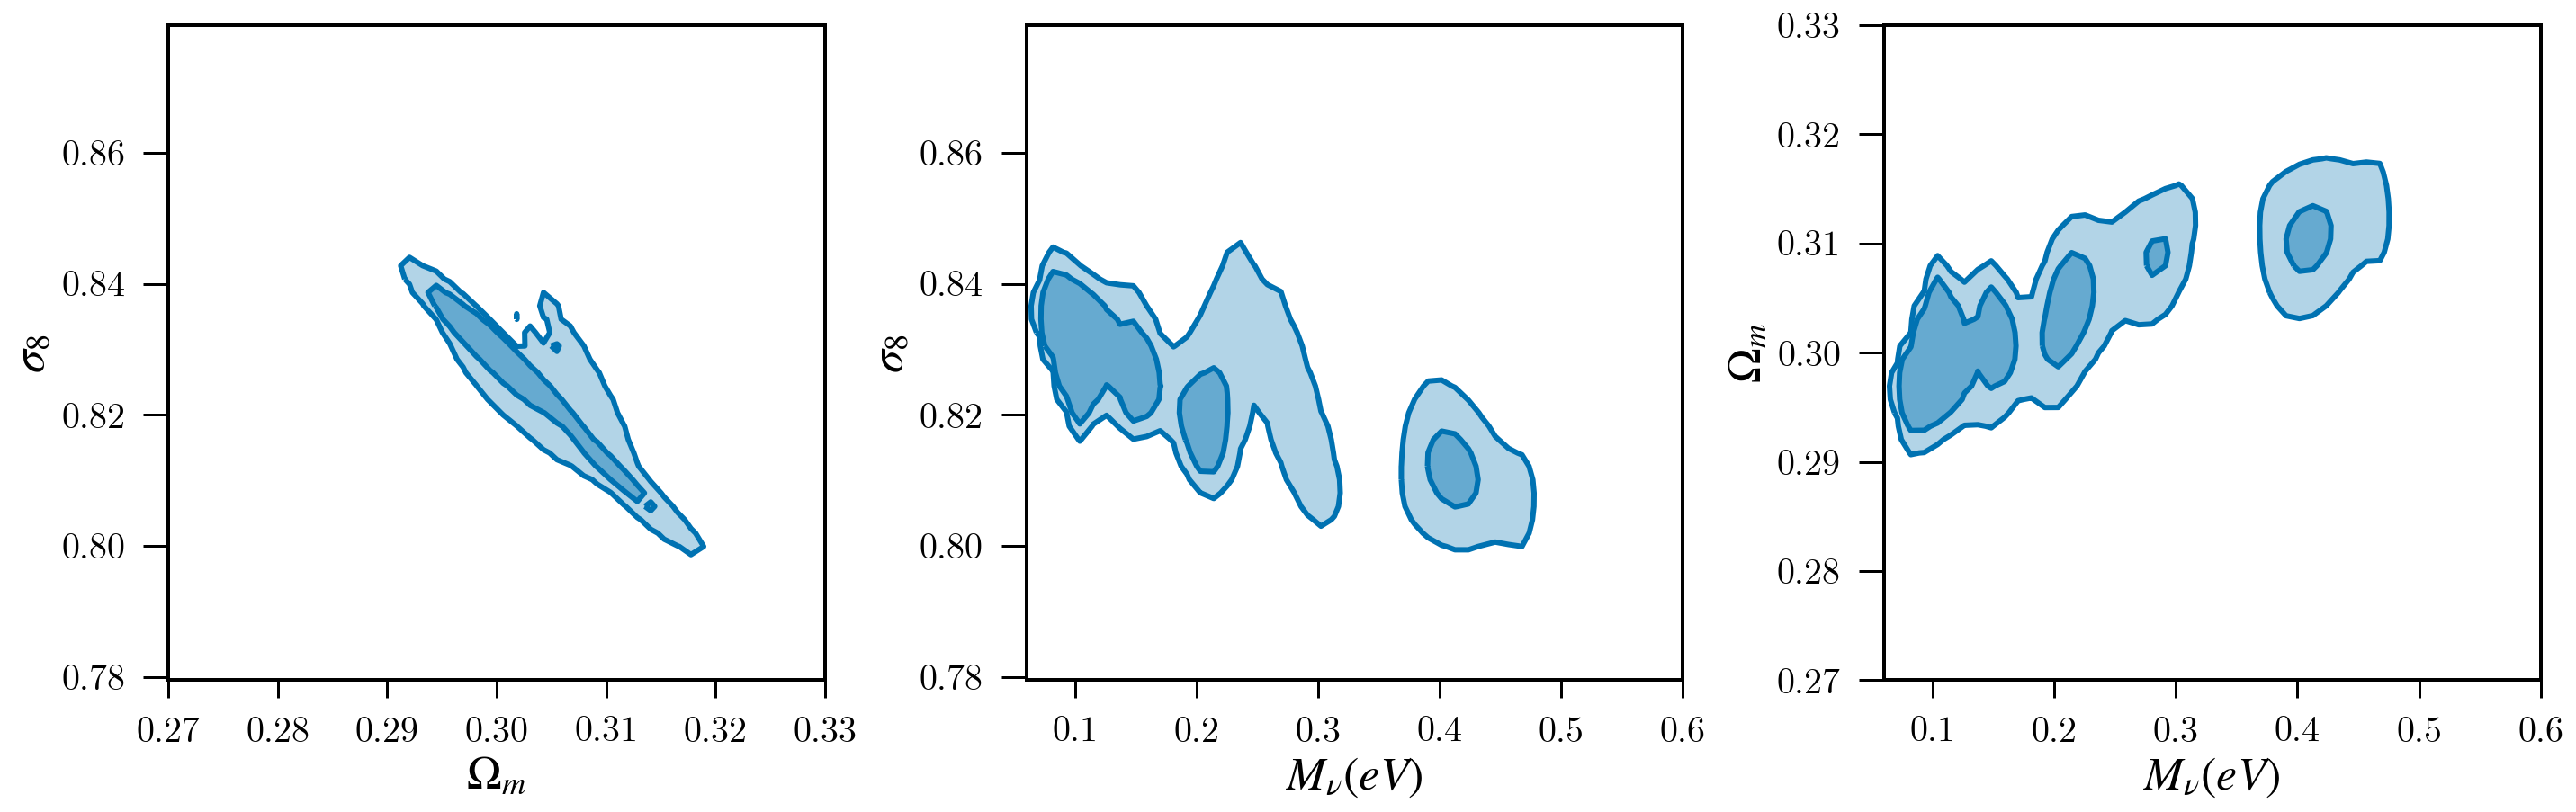

In [236]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/ng40_PC_bin50_eKNcKN_xyz.npy' )
c2 = np.load( 'cubes/ng40_PC_bin50_eKNcKN.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[1],
                       input_label='new')
fig.tight_layout()

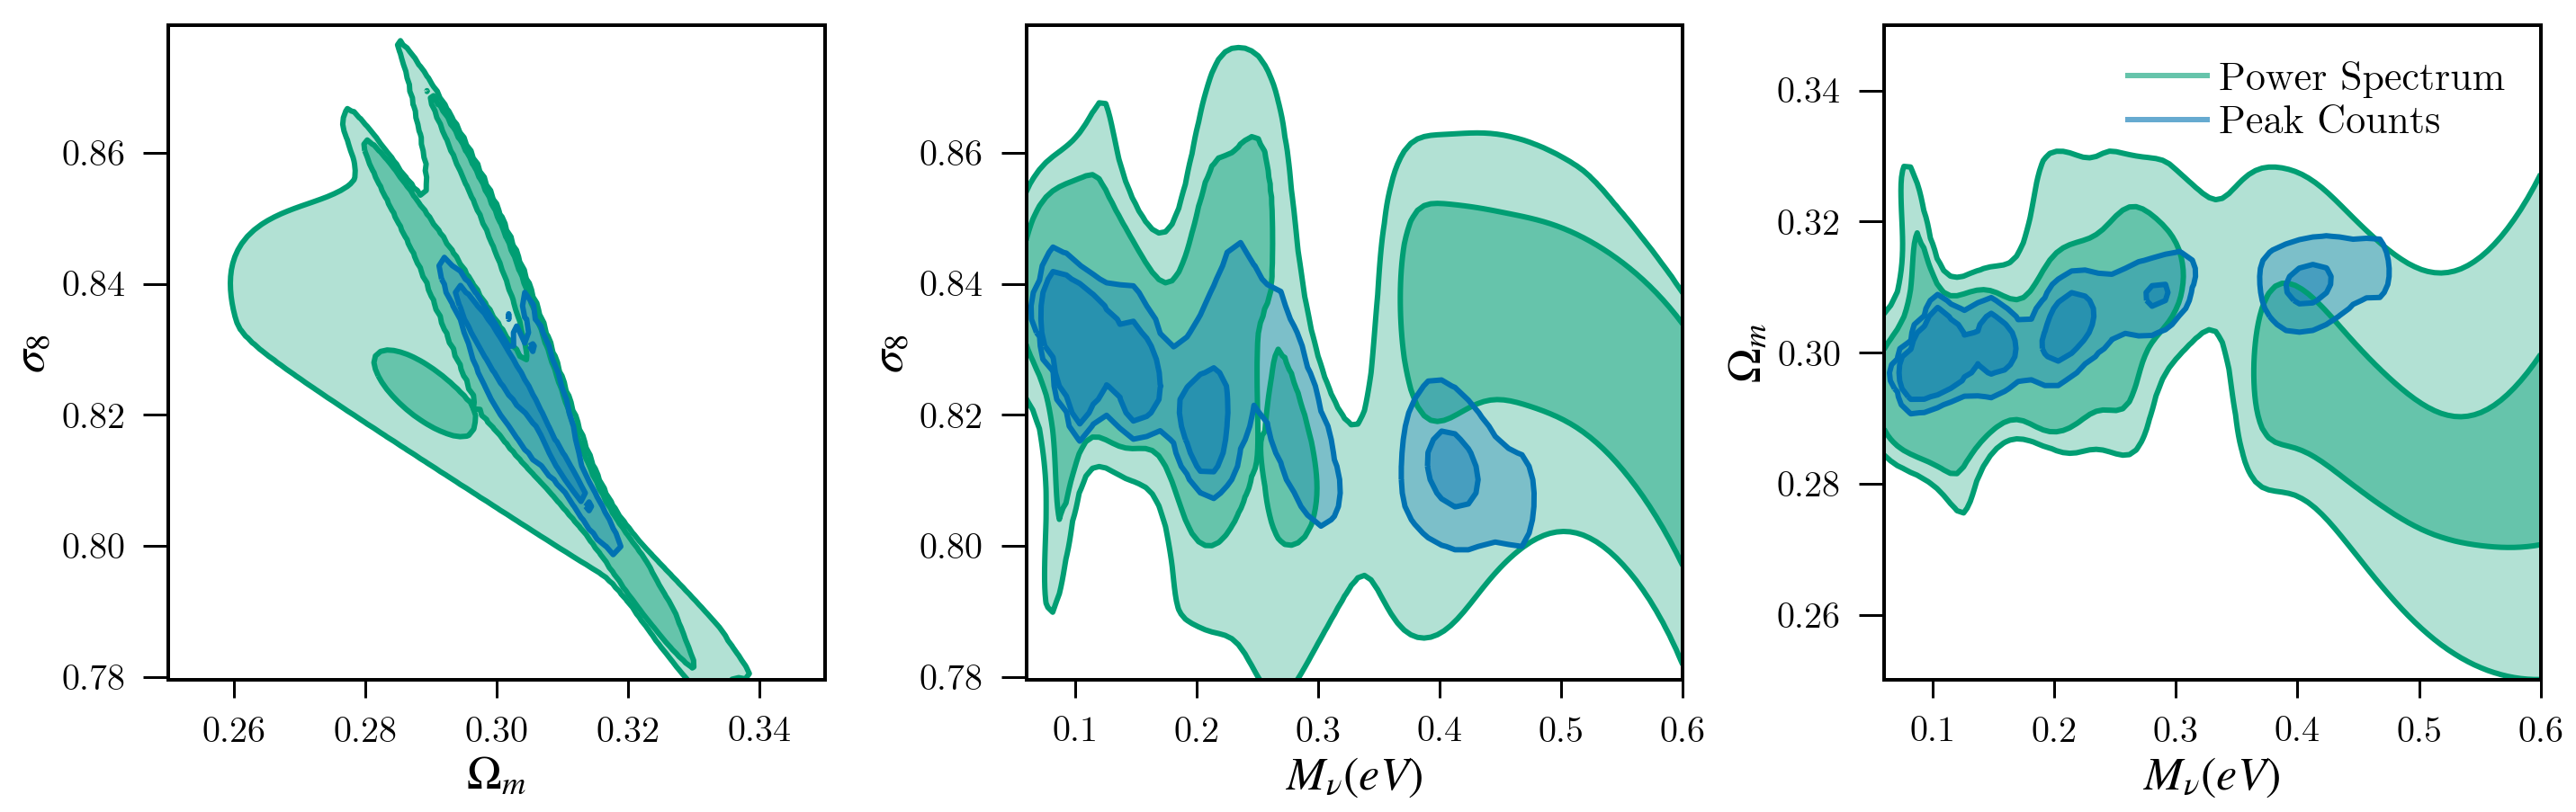

In [239]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/ng40_PS_bin50_eKNcK_xyz.npy' )
c2 = np.load( 'cubes/ng40_PS_bin50_eKNcK.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[2],
                       input_label='Power Spectrum')
x,y,z = np.load(  'cubes/ng40_PC_bin50_eKNcKN_xyz.npy' )
c2 = np.load( 'cubes/ng40_PC_bin50_eKNcKN.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, fig=fig, axes=axes,
                        input_color=default_color_list[1],
                       input_label='Peak Counts')
fig.tight_layout()

plt.legend()

# Compare PS to smoothing scale PC

In [12]:
%%time
ell, ps_mean = get_meanstack_multiz( 'Peaks', noisy='K', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=-0.05, bin_max=100, smoothing='1.00' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=-0.05, bin_max=100, smoothing='1.00')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

nres = 30
x = np.linspace(0.06, 0.1 + 0.1, nres) # M_nu
y = np.linspace(0.3 - 0.02, 0.3 + 0.02, nres) # omega_m
z = np.linspace(0.8295 - 0.02, 0.8295 + 0.02, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PC_s1.npy', cube)
np.save( 'cubes/5z_PC_s1_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 234 bin 0.9764952990598119 sky 0.001225
CPU times: user 24.9 s, sys: 3.19 s, total: 28.1 s
Wall time: 9min 7s


In [13]:
%%time
ell, ps_mean = get_meanstack_multiz( 'Peaks', noisy='K', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=-0.05, bin_max=100, smoothing='2.00' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=-0.05, bin_max=100, smoothing='2.00')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

nres = 30
x = np.linspace(0.06, 0.1 + 0.1, nres) # M_nu
y = np.linspace(0.3 - 0.02, 0.3 + 0.02, nres) # omega_m
z = np.linspace(0.8295 - 0.02, 0.8295 + 0.02, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PC_s2.npy', cube)
np.save( 'cubes/5z_PC_s2_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 250 bin 0.9748949789957991 sky 0.001225
CPU times: user 27.3 s, sys: 3.28 s, total: 30.6 s
Wall time: 9min 14s


In [14]:
%%time
ell, ps_mean = get_meanstack_multiz( 'Peaks', noisy='K', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=-0.05, bin_max=100, smoothing='5.00' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=-0.05, bin_max=100, smoothing='5.00')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

nres = 30
x = np.linspace(0.06, 0.1 + 0.1, nres) # M_nu
y = np.linspace(0.3 - 0.02, 0.3 + 0.02, nres) # omega_m
z = np.linspace(0.8295 - 0.02, 0.8295 + 0.02, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PC_s5.npy', cube)
np.save( 'cubes/5z_PC_s5_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 250 bin 0.9748949789957991 sky 0.001225
CPU times: user 36.5 s, sys: 5.86 s, total: 42.4 s
Wall time: 9min 13s


In [21]:
%%time
ell, ps_mean = get_meanstack_multiz( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'],  
                               bin_min=-0.05, bin_max=100, smoothing='5.00' )
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

# remove the 0th row (fiducial A)
ps_mean = np.delete(ps_mean, 0, axis=0)
params = np.delete(params, 0, axis=1)
invcov = get_invcov( 'Peaks', noisy='KN', redshifts=['05', '10', '15', '20', '25'], 
                                   bin_min=-0.05, bin_max=100, smoothing='5.00')
# construct interpolator for PS
test_interp_ps = Interp(obsarr=ps_mean,
                        cosmo_params=params,
                        invcov=invcov,
                        fiducial_model=ps_mean[0]) # IMPORTANT: REMOVED FIRST, SO NOW FIDUCIAL IS MODEL 0

nres = 30
x = np.linspace(0.06, 0.1 + 0.1, nres) # M_nu
y = np.linspace(0.3 - 0.02, 0.3 + 0.02, nres) # omega_m
z = np.linspace(0.8295 - 0.02, 0.8295 + 0.02, nres) # sigma_8
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
input_param_list = list(zip(np.ravel(X), np.ravel(Y), np.ravel(Z)))

p = mp.Pool(16)  # Processing Pool with 16 cores (adjust for your own machine)
cube = np.array(p.map(test_interp_ps.P, input_param_list ))
cube = cube.reshape(X.shape)
p.close()
np.save('cubes/5z_PC_s5_mN.npy', cube)
np.save( 'cubes/5z_PC_s5_mN_xyz.npy', np.array([x,y,z]) )

nr 9999 nb 250 bin 0.9748949789957991 sky 0.001225
CPU times: user 26.2 s, sys: 3.41 s, total: 29.6 s
Wall time: 9min 16s


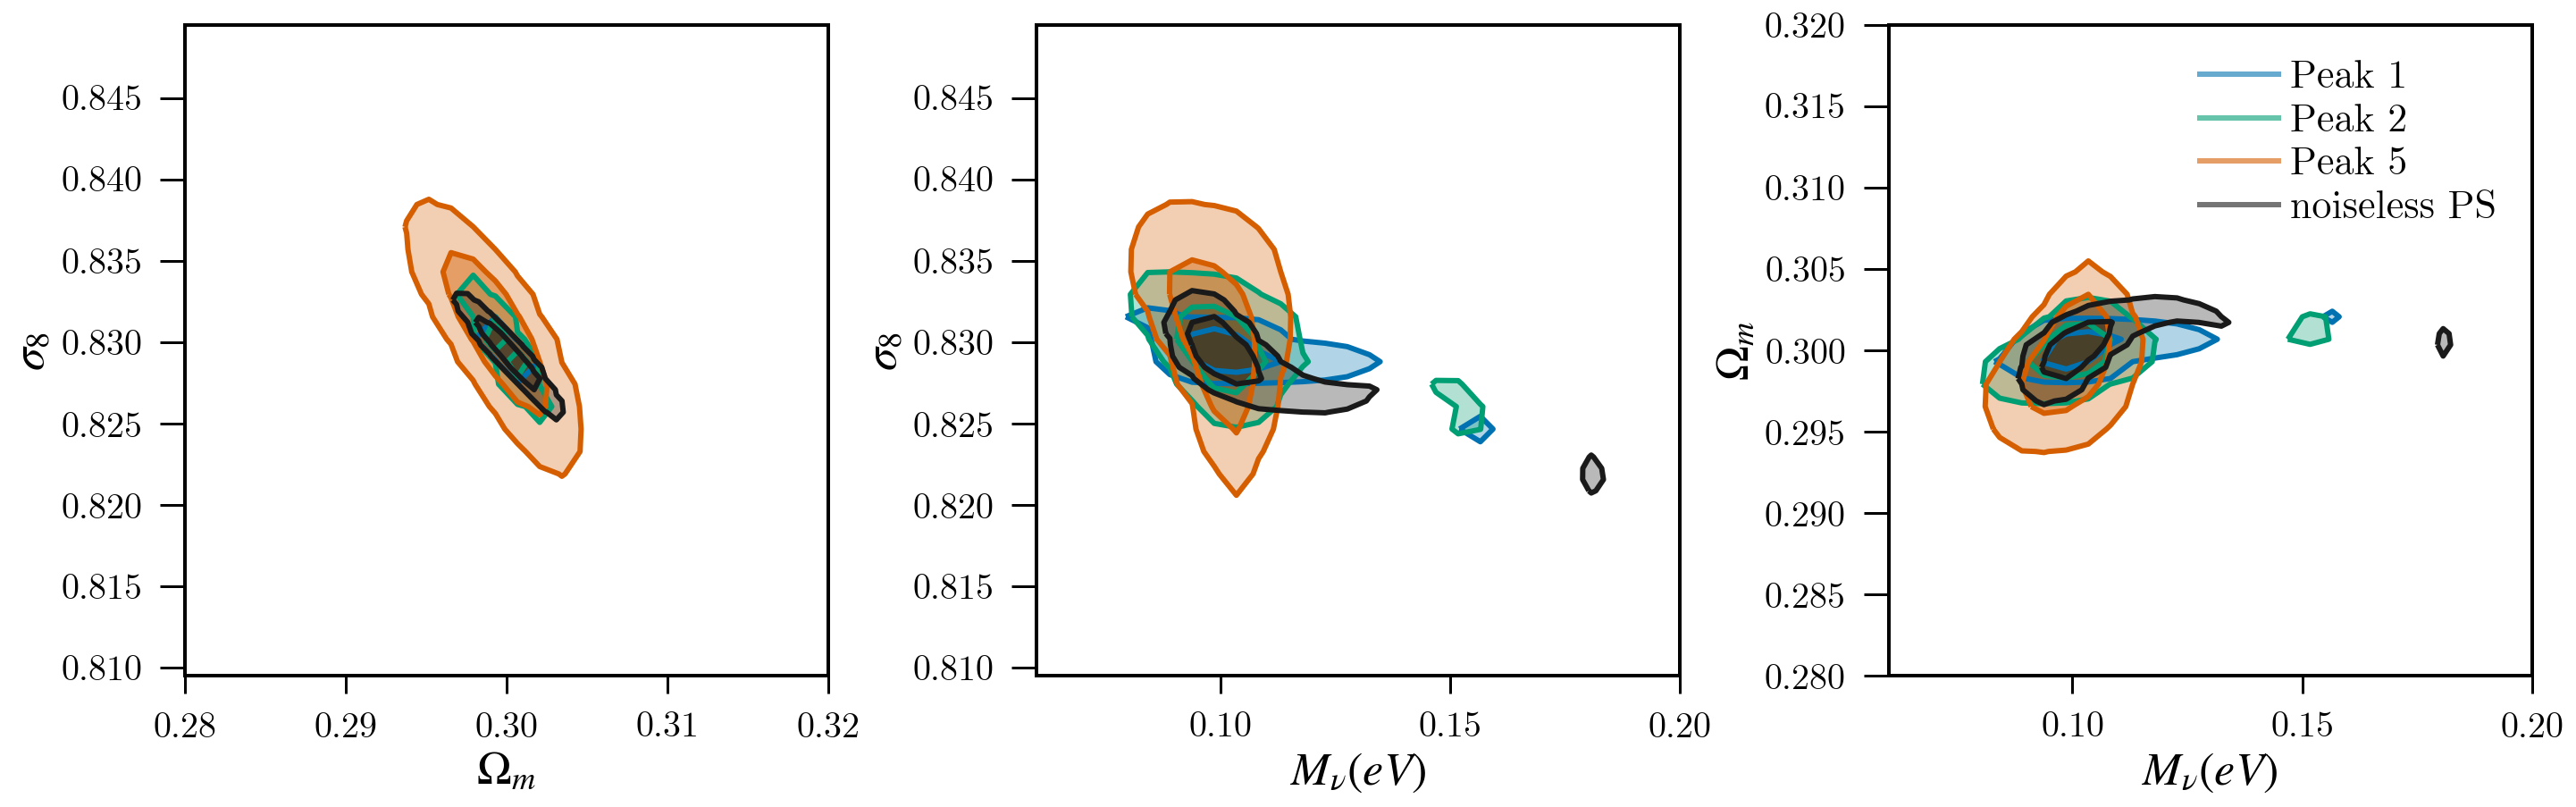

In [20]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/5z_PC_s1_xyz.npy' )
c2 = np.load( 'cubes/5z_PC_s1.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[1],
                       input_label='Peak 1')
x,y,z = np.load(  'cubes/5z_PC_s2_xyz.npy' )
c2 = np.load( 'cubes/5z_PC_s2.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, fig=fig, axes=axes,
                        input_color=default_color_list[2],
                       input_label='Peak 2')
x,y,z = np.load(  'cubes/5z_PC_s5_xyz.npy' )
c2 = np.load( 'cubes/5z_PC_s5.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, fig=fig, axes=axes,
                        input_color=default_color_list[3],
                       input_label='Peak 5')

x,y,z = np.load(  'cubes/5z_PS_bin50_eKcK_xyz_nr5000.npy' )
c2 = np.load( 'cubes/5z_PS_bin50_eKcK_nr5000.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fig=fig, axes=axes, fill=True, 
                        input_color=default_color_list[0],
                       input_label='noiseless PS')


fig.tight_layout()

plt.legend()

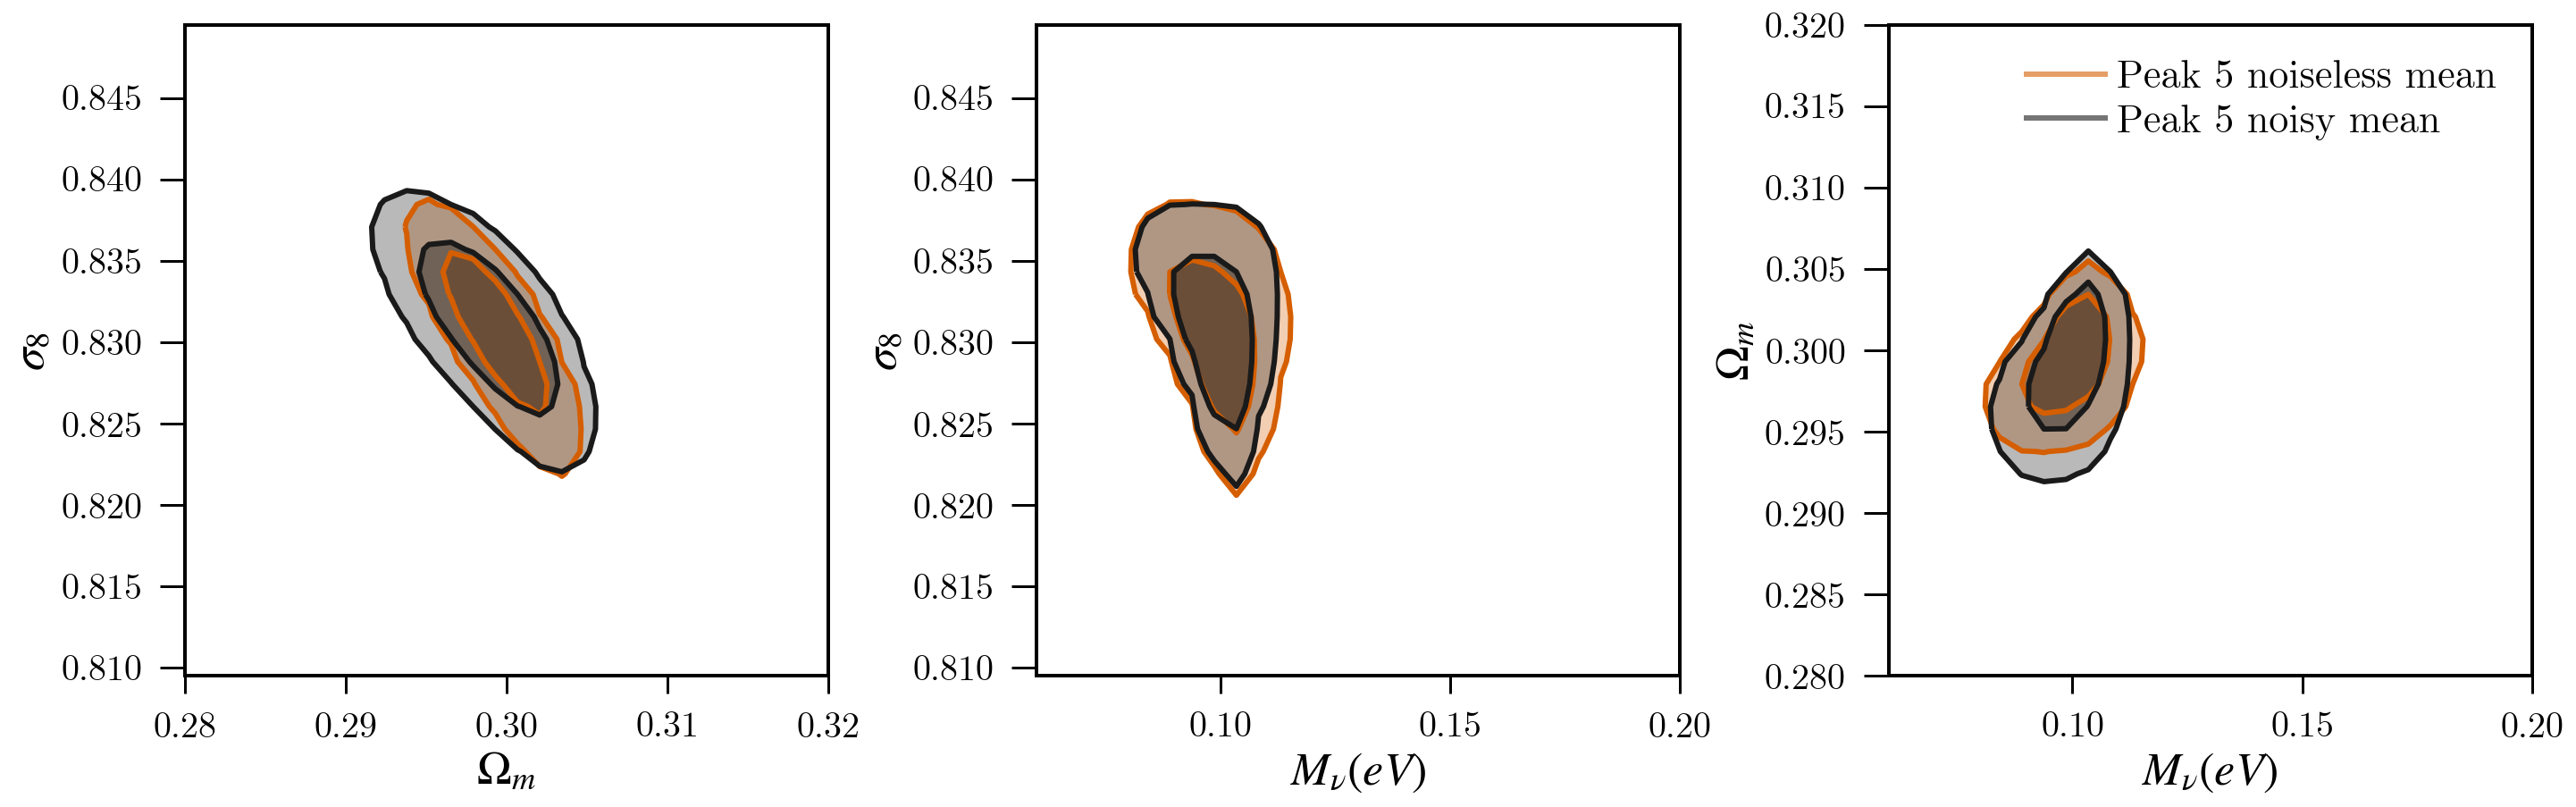

In [31]:


import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/5z_PC_s5_xyz.npy' )
c2 = np.load( 'cubes/5z_PC_s5.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True,
                        input_color=default_color_list[3],
                       input_label='Peak 5 noiseless mean')

x,y,z = np.load(  'cubes/5z_PC_s5_mN_xyz.npy' )
c2 = np.load( 'cubes/5z_PC_s5_mN.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fig=fig, axes=axes, fill=True, 
                        input_color=default_color_list[0],
                       input_label='Peak 5 noisy mean')

# plt.suptitle('noisy cov', fontsize=30)
fig.tight_layout()

plt.legend()

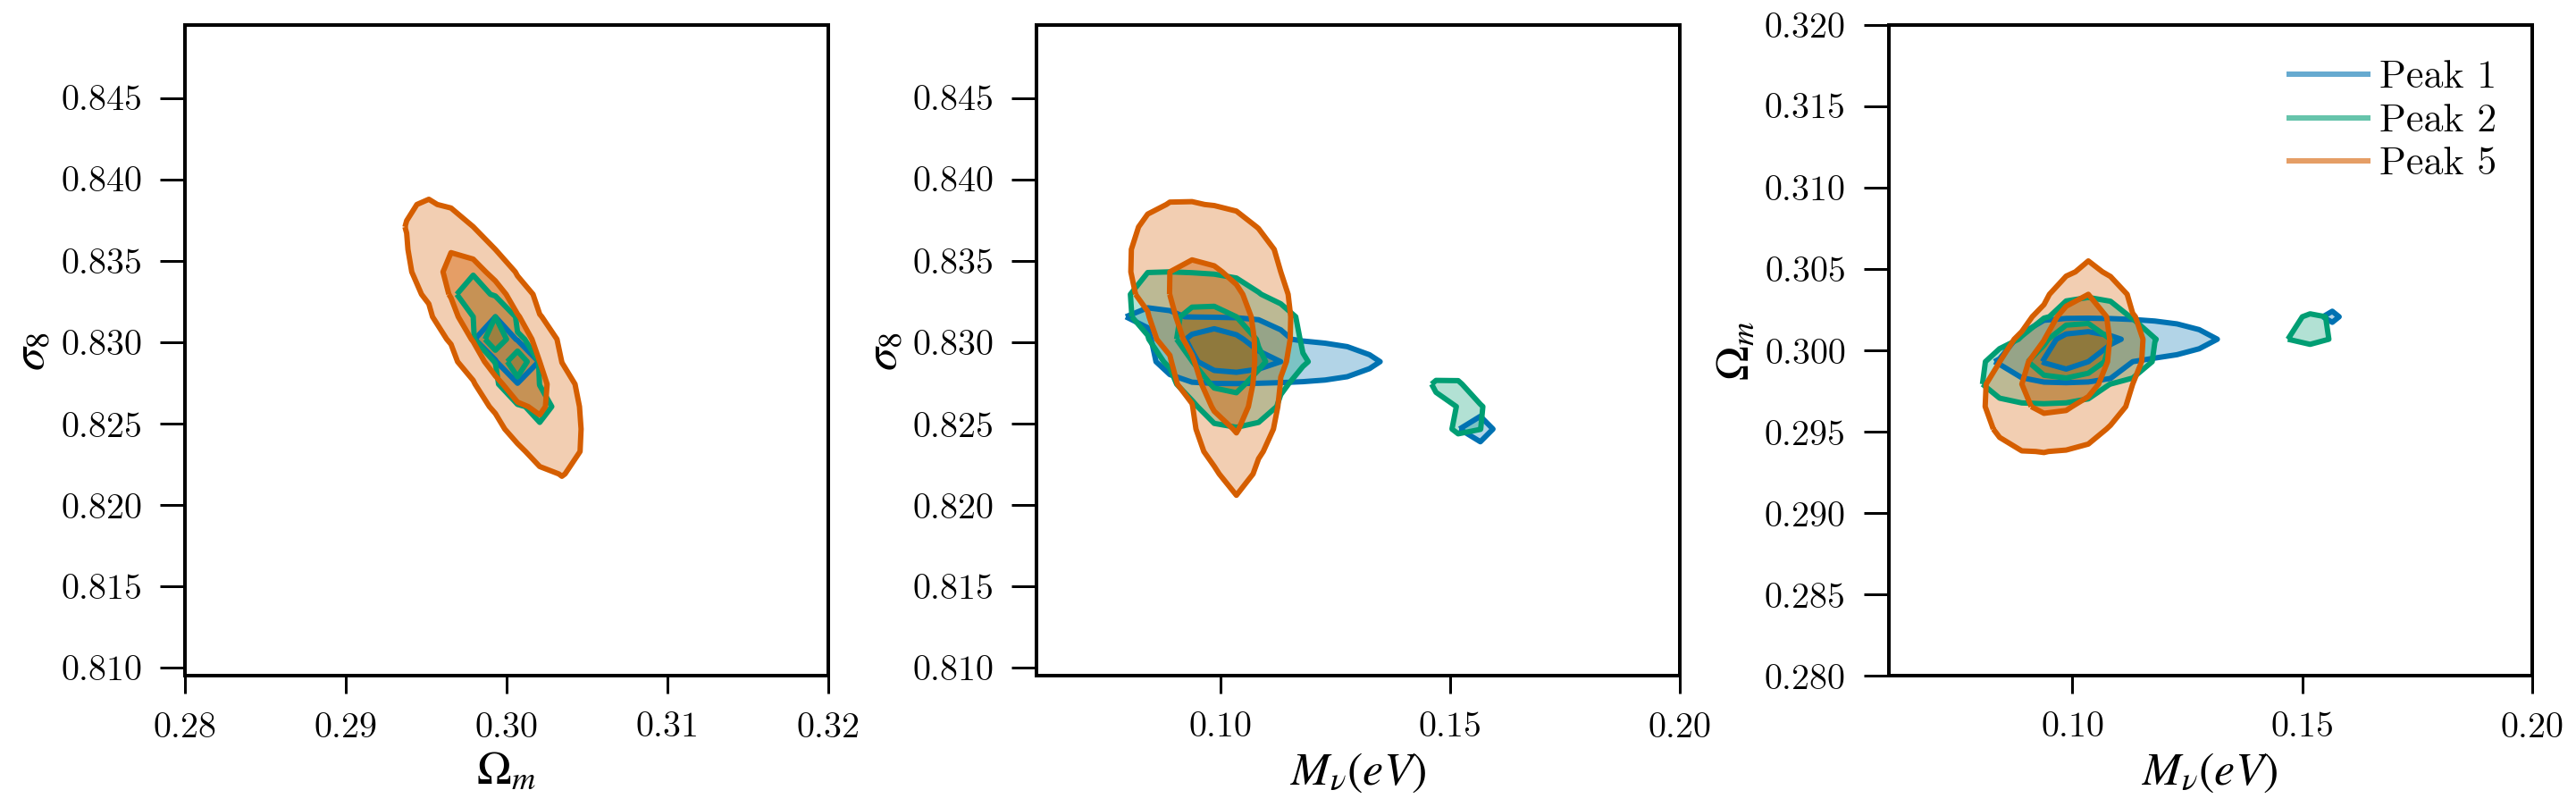

In [25]:
import plot_utils
params = np.array([table['M_nu(eV)'], table['Omega_m'], table['sigma_8(derived)']])

x,y,z = np.load(  'cubes/5z_PC_s1_xyz.npy' )
c2 = np.load( 'cubes/5z_PC_s1.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, 
                        input_color=default_color_list[1],
                       input_label='Peak 1')
x,y,z = np.load(  'cubes/5z_PC_s2_xyz.npy' )
c2 = np.load( 'cubes/5z_PC_s2.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, fig=fig, axes=axes,
                        input_color=default_color_list[2],
                       input_label='Peak 2')
x,y,z = np.load(  'cubes/5z_PC_s5_xyz.npy' )
c2 = np.load( 'cubes/5z_PC_s5.npy' )
fig, axes = plot_utils.plot_cube_getdist_style(c2, [x,y,z], fill=True, fig=fig, axes=axes,
                        input_color=default_color_list[3],
                       input_label='Peak 5')


fig.tight_layout()

plt.legend()